In [1]:
# This document is for making 3D plots of MHD-AEPIC runs, using both PIC and MHD data. 
# The PIC data and MHD data can be read in at two different cadences. The PIC data overrides the MHD data

# Essential Jupyter Notebook Magic
%matplotlib inline

# General Purpose and Data Handling Libraries
import os
import re
import glob
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from natsort import natsorted
import pickle
from operator import add
import random
import math

# MatPlotlib for Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm, LightSource, ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import LogFormatter, LogFormatterSciNotation
from matplotlib.ticker import LogLocator, MultipleLocator, NullFormatter
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from streamtracer import StreamTracer, VectorGrid
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from cmap import Colormap
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Scipy for Scientific Computing and Analysis
from scipy import stats, interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import label, gaussian_filter
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import RegularGridInterpolator
from skimage import measure
from shapely.geometry import Polygon
from scipy.ndimage import zoom
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats import linregress

# Image Handling and Processing
from PIL import Image

# Tecplot for Scientific Data Visualization
import tecplot as tp
from tecplot.exception import *
from tecplot.constant import *

# For 3d plotting
from skimage import measure


In [2]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath,port=7605):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=port)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bx_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bx at each point
    
    return - 200.9 * 3 * (z_array-0.2) * x_array/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def By_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: By at each point
    
    return - 200.9 * 3 * (z_array-0.2) * y_array/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def get_files(dir, start_time, t_bound, dt, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()

    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]

    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for file_time in list(named_files.keys()):#[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            if t_bound[0]<=float(file_time)<t_bound[1]:
                reduced_files[file_time] = str(named_files[file_time])
        return reduced_files

    else:
        return named_files

def dat_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))
        os.remove(str(dir+files[file]))
        print(f"Deleted original .dat file: {files[file]}")

def plt_to_numpy(dataset,var_ls=["Bz"],save_cs = True):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("duix_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{duix_dx} = (ddx({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dx} = (ddx({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dx} = (ddx({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dy} = (ddy({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dy} = (ddy({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dy} = (ddy({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dz} = (ddz({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dz} = (ddz({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dz} = (ddz({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                                rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smoothing parameter
        smoothing_param = 5
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 

def MHD_to_numpy(dataset,x_axis,y_axis,z_axis,var_ls=["Bz"],save_cs = True, smoothing_param = 5/8):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Create an ordered zone`
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X [[]R[]]')[:] = xxx.ravel()
    rect_zone.values('Y [[]R[]]')[:] = yyy.ravel()
    rect_zone.values('Z [[]R[]]')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = {P [[]nPa[]]}/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("dux_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{dux_dx} = (ddx({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dx} = (ddx({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dx} = (ddx({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dy} = (ddy({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dy} = (ddy({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dy} = (ddy({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dz} = (ddz({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dz} = (ddz({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dz} = (ddz({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*rect_zone.values("P [[]nPa[]]").as_numpy_array()*1e9/(rect_zone.values("B_x [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_y [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_z [[]nT[]]").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.abs(zzz-0.2)>0.75] = 0 # We don't want to fit to current sheets other than the neutral sheet, so preemptively resttrict the search area to z-0.2 += 0.5
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    # Sse 0.2 if it tries to go too far away from the magnetic equator
                    #if (np.abs(zzz[idy,idx,idz] - 0.2)>0.5):
                    #    Z_rough[idy,idx] = 0.2
                    #else:
                    Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 


def smooth_meshgrid(X, Y, Z, smoothing_param):
    """
    Smooth the Z values of a meshgrid defined by X, Y coordinates using a Gaussian filter.
    
    Parameters:
    X (2D numpy array): The X coordinates of the meshgrid.
    Y (2D numpy array): The Y coordinates of the meshgrid.
    Z (2D numpy array): The Z coordinates of the meshgrid.
    smoothing_param (float): The standard deviation for the Gaussian kernel, controlling the smoothing.
    
    Returns:
    Z_smoothed (2D numpy array): The smoothed Z values of the meshgrid.
    """
    # Check if X, Y, Z are of the same shape
    if X.shape != Y.shape or X.shape != Z.shape:
        raise ValueError("X, Y, and Z meshgrids must have the same shape")
    
    # Apply Gaussian filter to the Z meshgrid
    Z_smoothed = gaussian_filter(Z, sigma=smoothing_param)
    
    return Z_smoothed

def plot_sphere(ax, u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi, 100), radius=1, center=(0, 0, 0), color='b', alpha=0.5, zorder = 1, xlims = [-10,10], ylims = [-10,10], zlims = [-10,10]):
    """
    Plots a sphere of given radius centered at center on the provided 3D axis.
    
    Parameters:
    - ax: The 3D axis to plot the sphere on.
    - radius: The radius of the sphere (default: 1).
    - center: The (x, y, z) coordinates of the sphere's center (default: (0, 0, 0)).
    - color: The color of the sphere (default: blue).
    - alpha: The transparency of the sphere (default: 0.5).
    """
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

    # Mask out any values outside the axes lims
    mask = (x < xlims[0]) | (x > xlims[1]) | (y < ylims[0]) | (y > ylims[1]) | (z < zlims[0]) | (z > zlims[1]) 
    x[mask] = np.nan
    y[mask] = np.nan
    z[mask] = np.nan

    ax.plot_surface(x, y, z, color=color, alpha=alpha, zorder=zorder)

def average_value(var_ls,t0,t_start,t_stop,type='csdata',domain="PIC"):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Type can be csdata for just the current sheet, or numpy for the 3d date
    # Domain can be MHD or PIC, to choose which type of output to use
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    if domain == "PIC":
        temp_files = get_files(dir,PIC_start_time,t_bound,PIC_dt,key="3d\_fluid.*"+type+"\_t\_...\...",read_time = True, reduce = False)
    elif domain == "MHD":
        temp_files = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var.*"+type+"\_t\_...\...",read_time = True, reduce = False)
    else:
        print("Invalid domain!")
        return
    #print("Averaging over files from",list(temp_files.values())[0],"to",list(temp_files.values())[-1])
    print("Beginning",type,domain,"averaging")

    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            print("Adding t=",t)
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def find_indices(X, Y, XX, YY):
    # Function used to get ix and iy for some coordinates X and Y
    X = np.array(X)
    Y = np.array(Y)
    XX = np.array(XX)
    YY = np.array(YY)

    ix = []
    iy = []
    
    for (x, y) in zip(X, Y):
        # Find the closest index in the meshgrid for the x coordinate
        ix_index = np.abs(XX[0] - x).argmin()
        # Find the closest index in the meshgrid for the y coordinate
        iy_index = np.abs(YY[:, 0] - y).argmin()
        
        ix.append(ix_index)
        iy.append(iy_index)
        
    return iy, ix

def remove_duplicate_rows(arr):
    # Used in df_tracker... does something to remove repeated rows in the matching matrix
    seen = set()
    filtered_rows = []
    for row in arr:
        if row[0] not in seen:
            filtered_rows.append(row)
            seen.add(row[0])
    return np.array(filtered_rows)

def find_boundary_points(X, Y):
    # Combine the coordinate lists into a single array of points
    points = np.column_stack((X, Y))

    # Compute the convex hull of the points
    hull = ConvexHull(points)

    # Extract the boundary points
    boundary_points = hull.vertices

    # Boundary points in original coordinate lists
    boundary_X = points[boundary_points, 0]
    boundary_Y = points[boundary_points, 1]

    return boundary_X.tolist(), boundary_Y.tolist()

def create_above_surface_mask(X, Y, Z, XX, YY, ZZ):
    # Works out all the 3D points above a 2D surface ie all the points above the current sheet.
    # Used for 3D plotting to determine what is above what.
    # Check that XX, YY, ZZ have the same shape
    assert XX.shape == YY.shape == ZZ.shape, "Arrays XX, YY, and ZZ must have the same shape"
    
    # Check that X, Y, Z have the same shape
    assert X.shape == Y.shape == Z.shape, "Arrays X, Y, and Z must have the same shape"

    # Determine the shape of the input arrays
    nx, ny, nz = XX.shape

    # Initialize a mask with the same shape as ZZ
    mask = np.zeros_like(ZZ, dtype=bool)

    # Iterate over the entire 3D meshgrid
    for i in range(nx):
        for j in range(ny):
            # Find the index in the 2D arrays corresponding to the x and y coordinates
            xi = np.argmin(np.abs(X[0] - XX[i, j, 0]))
            yi = np.argmin(np.abs(Y[:, 0] - YY[i, j, 0]))

            # Compare ZZ with Z to determine the mask
            mask[i, j, :] = ZZ[i, j, :] > Z[yi, xi]

    return mask


def compute_dt(var_ls,time,type='csdata'):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    #print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    if type=='csdata':
        temp_files = filescs
        data = datacs
    elif type=='numpy':
        temp_files = files3D
        data = data3d

    # Read in the data depending on whether its available
    if (key_minus in temp_files.keys()) and (key_plus in temp_files.keys()):
        # Case one: earlier and later timestep available, so use both
        #print("Earlier and later timesteps available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in temp_files.keys()):
        # Case two: only earlier time available
        #print("Only earlier timestep available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in temp_files.keys()):
        # Case three: only later time available
        #print("Only later timestep available!")
        print(dir+temp_files[key_plus])
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE AT TIME =",time)
            
    return deriv_dict

def plane_intersection(x, y, z, plane_z=0.2):
    # Used in 3D_df_tracker2 to check whether a given field line intersects the current sheet multiple times or not
    intersections = 0  # Counter for intersections with the plane

    # Iterate over the list of points
    for i in range(1, len(z)):
        if (z[i-1] - plane_z) * (z[i] - plane_z) < 0:
            # There is an intersection between z[i-1] and z[i] since their signs are different
            intersections += 1
        elif z[i-1] == plane_z and z[i] != plane_z:
            # Edge case: the point is exactly on the plane
            intersections += 1

    return intersections

def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x))

def symroot(x):
    """ Returns the symmetric sqrt value """
    return np.sign(x) * np.sqrt(np.abs(x))

# Functions for adding arrows; use "setattr(Axes3D, 'arrow3D', _arrow3D)" after defining your axes
class Arrow3D(FancyArrowPatch):
            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                
                return np.min(zs) 
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

In [3]:
############################## PREPROCESSING ##############################
#dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-2e/"
dir = "/Volumes/My Book Duo/runs/DR_run1/ta-2/"
#dir = "/Volumes/My Book Duo/runs/nightside_v5_run6/ta-1/"
pre_proc_MHD = True
MHD_start_time = 200  # First time step of MHD data saved in this directory
t_bound = [200,2000]    # Start and stop times of this data to be plot (cannot go beyond available PIC data time range)
MHD_dt = 1 # File time cadence of MHD data [s]
preproc_xlims = [-3,0]
preproc_ylims = [-1.5,1.5]
preproc_zlims = [-1.5,1.5]
MHD_var_ls = ["Rho [[]amu/cm^3[]]","U_x [[]km/s[]]","U_y [[]km/s[]]","U_z [[]km/s[]]","B_x [[]nT[]]","B_y [[]nT[]]","B_z [[]nT[]]",
             "P [[]nPa[]]","J_x [[]`mA/m^2[]]","J_y [[]`mA/m^2[]]","J_z [[]`mA/m^2[]]"]#,"dp_dx","dp_dy","dp_dz",
              #"dB_dx","dB_dy","dB_dz","dux_dx","duy_dx","duz_dx","dux_dy","duy_dy","duz_dy","dux_dz","duy_dz","duz_dz"]

PIC_var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz","duix_dx","duiy_dx","duiz_dx","duix_dy","duiy_dy","duiz_dy","duix_dz","duiy_dz","duiz_dz"]

# Cell data from PIC (found by directly examining the actual output grid)
PIC_xmin = -3.99219
PIC_ymin = -1.22656
PIC_zmin = -0.742188
PIC_dx = 0.01562501
dx_factor = 1 # The MHD grid will be limited to steps of this size factor 
PIC_dx1 = PIC_dx * dx_factor

############################## PREPROCESSING ##############################

if pre_proc_MHD:
    xmin_idx = int(round((PIC_xmin - preproc_xlims[0])/PIC_dx1,0)) # How many PIC_dx between PIC_xmin and preproc_xlims[0]
    ymin_idx = int(round((PIC_ymin - preproc_ylims[0])/PIC_dx1,0))
    zmin_idx = int(round((PIC_zmin - preproc_zlims[0])/PIC_dx1,0))
    xmax_idx = int(round((preproc_xlims[1] - PIC_xmin)/PIC_dx1,0))
    ymax_idx = int(round((preproc_ylims[1] - PIC_ymin)/PIC_dx1,0))
    zmax_idx = int(round((preproc_zlims[1] - PIC_zmin)/PIC_dx1,0))

    MHD_xlims = [PIC_xmin - xmin_idx*PIC_dx1, PIC_xmin + xmax_idx*PIC_dx1]
    MHD_ylims = [PIC_ymin - ymin_idx*PIC_dx1, PIC_ymin + ymax_idx*PIC_dx1]
    MHD_zlims = [PIC_zmin - zmin_idx*PIC_dx1, PIC_zmin + zmax_idx*PIC_dx1]

    MHD_xaxis = np.arange(MHD_xlims[0],MHD_xlims[1]+PIC_dx1,PIC_dx1)
    MHD_yaxis = np.arange(MHD_ylims[0],MHD_ylims[1]+PIC_dx1,PIC_dx1)
    MHD_zaxis = np.arange(MHD_zlims[0],MHD_zlims[1]+PIC_dx1,PIC_dx1)
    
    MHD_files = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*\.plt",reduce = True)
    for time in list(MHD_files.keys()): 
        print("Preprocessing MHD data for t =",time)
        file = str(MHD_files[time])
    
        # Read in dataset
        dataset = read_dataset(dir+file,port=7601)
        # Save .plt as numpy data
        data = MHD_to_numpy(dataset,MHD_xaxis,MHD_yaxis,MHD_zaxis,var_ls=MHD_var_ls)
    

Preprocessing MHD data for t = 200
reading: /Volumes/My Book Duo/runs/DR_run1/ta-2/3d__var_3_t00000320_n00939179.plt



KeyboardInterrupt



In [4]:
############################## USER INPUT ##############################

# Plotting control parameters
# Directory data
#dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"   # Directory with data 
dir = "/Volumes/My Book Duo/runs/DR_run1/ta-2/"
#dir = "/Volumes/My Book Duo/runs/nightside_v5_run6/ta-1/"

# Time range: this sets the times and timing of the plots
t_bound = [200,2000000]    # Start and stop times of this data to be plot (cannot go beyond available PIC data time range) If using a time-averaged plotting function, this sets the time bounds of when to average over
PIC_start_time = 60  # First time step of PIC data saved in this directory
MHD_start_time = 200  # First time step of MHD data saved in this directory
PIC_dt = 0.05  # File time cadence of PIC data [s]
MHD_dt = 1 # File time cadence of MHD data [s]
cell_size = R_M/64  # Edge length of Pic cell, in m

# Spatial range: this sets the spatial extent of the data to be loaded in
xlims = [-3,0]
ylims = [-1.5,1.5]
zlims = [-1.5,1.5]

# Zoom region: where the data should be zoomed to view
xlims_zoom = [-2.25,-0.25]
ylims_zoom = [-1.5,1.5]
zlims_zoom = [-0.6,1.0]

# Viewing angle
azim = -135
elev = 35

# Smoothing scale for current sheet fit (best to use 8, which is standard for PIC postproc)
smoothing_param = 8

# Testing -- enable if data is already read in and we are just adjusting a plot
plot_testing = True

# Read data -- some plots, like "hybrid_flux_tube_entropy", have expensive computations that save the data as they go. When true, this command says to read those files rather than compute from scratch
read_data = True

# Plot presets
plot_preset = "MHD_DR_plot2"
'''
"hybrid_Bz1": Bz1 in stated domain.

"hybrid_Jy": Jy in stated domain.

"hybrid_flux_tube_entropy": 

"hybrid_plasma_sheet_position_average": *uses averaging*

"hybrid_plasma_sheet_current_average": *uses averaging*

"hybrid_plasma_sheet_average": *uses averaging*

"MHD_DR_plot1": Only uses MHD data,
'''

############################## USER INPUT ##############################

var_matching = {"X":"X","Y":"Y","Z":"Z",
                "Bx":"B_x [[]nT[]]","By":"B_y [[]nT[]]","Bz":"B_z [[]nT[]]",
                "Ex":None,"Ey":None,"Ez":None,
                "rhoS0":"Rho [[]amu/cm^3[]]",
                "uxS0":None,"uyS0":None,"uzS0":None,
                "pxxS0":None,"pyyS0":None,"pzzS0":None,"pxyS0":None,"pxzS0":None,"pyzS0":None,
                "rhoS1":"Rho [[]amu/cm^3[]]",
                "uxS1":"U_x [[]km/s[]]","uyS1":"U_y [[]km/s[]]","uzS1":"U_z [[]km/s[]]",
                "pxxS1":None,"pyyS1":None,"pzzS1":None,"pxyS1":None,"pxzS1":None,"pyzS1":None,
                "Jx":"J_x [[]`mA/m^2[]]","Jy":"J_y [[]`mA/m^2[]]","Jz":"J_z [[]`mA/m^2[]]",
                "dp_dx":"dp_dx","dp_dy":"dp_dy","dp_dz":"dp_dz",
                "dB_dx":"dB_dx","dB_dy":"dB_dy","dB_dz":"dB_dz",
                "duix_dx":"dux_dx","duiy_dx":"duy_dx","duiz_dx":"duz_dx",
                "duix_dy":"dux_dy","duiy_dy":"duy_dy","duiz_dy":"duz_dy",
                "duix_dz":"dux_dz","duiy_dz":"duy_dz","duiz_dz":"duz_dz",
                "p_scalar":"P [[]nPa[]]"}

In [260]:
# Begin plotting
# Get all the files in the time range
if plot_preset[0:4] == 'MHD':
    print("ERROR: USING MHD ONLY PLOT MODE, PLEASE USE CELL BLOCK BELOW INSTEAD")
    
PIC_files_3D = get_files(dir,PIC_start_time,t_bound,PIC_dt,key="3d\_fluid.*numpy\_t\_...\...",read_time = True,reduce = True)
PIC_files_cs = get_files(dir,PIC_start_time,t_bound,PIC_dt,key="3d\_fluid.*csdata\_t\_...\...",read_time = True,reduce = True)
MHD_files_3D = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*numpy\_t\_...\...",read_time = True,reduce = True)
MHD_files_cs = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*csdata\_t\_...\...",read_time = True,reduce = True)

# Begin iteration loop
iter = 0
print("Plotmode:",plot_preset)
for time_str in list(PIC_files_3D.keys()): 
    time = float(time_str)
    print("Plotting t =",time)

    ############################## DATASET FORMATION START ##############################

    if not plot_testing:
        # For plotting modes that use time-averaged data, we will read in all the files and average them
        if plot_preset in ["hybrid_plasma_sheet_position_average","hybrid_plasma_sheet_current_average","hybrid_plasma_sheet_average"]:
            PIC_data_3D = average_value(["X","Y","Z"]+PIC_var_ls,time,t_bound[0]-time,t_bound[1]-time,type='numpy',domain="PIC")
            PIC_data_cs = average_value(["X","Y","Z"]+PIC_var_ls,time,t_bound[0]-time,t_bound[1]-time,type='csdata',domain="PIC")
        # All other cases: just read in a single time
        else:
            # Read in the 3D PIC data
            my_file = str(PIC_files_3D[time_str])
            with open(dir+my_file, 'rb') as f:
                PIC_data_3D = pickle.load(f) 
        
            # Read in the cs PIC data
            my_file = str(PIC_files_cs[time_str])
            with open(dir+my_file, 'rb') as f:
                PIC_data_cs = pickle.load(f) 
    
        # Compute the coordinate axes for the data
        if iter==0:
            dx_ls = []
            for i in range(1,len(PIC_data_3D['X'][0,:,0])):
            
                dx_ls.append(PIC_data_3D['X'][0,i,0] - PIC_data_3D['X'][0,i-1,0])
            PIC_dx = np.mean(dx_ls)
            
            xmin_idx = int(round((np.min(PIC_data_3D['X']) - xlims[0])/PIC_dx,0)) # How many PIC_dx between PIC_xmin and preproc_xlims[0]
            ymin_idx = int(round((np.min(PIC_data_3D['Y']) - ylims[0])/PIC_dx,0))
            zmin_idx = int(round((np.min(PIC_data_3D['Z']) - zlims[0])/PIC_dx,0))
            xmax_idx = int(round((xlims[1] - np.min(PIC_data_3D['X']))/PIC_dx,0))
            ymax_idx = int(round((ylims[1] - np.min(PIC_data_3D['Y']))/PIC_dx,0))
            zmax_idx = int(round((zlims[1] - np.min(PIC_data_3D['Z']))/PIC_dx,0))
            
            corrected_xlims = [np.min(PIC_data_3D['X']) - xmin_idx*PIC_dx, np.min(PIC_data_3D['X']) + xmax_idx*PIC_dx]
            corrected_ylims = [np.min(PIC_data_3D['Y']) - ymin_idx*PIC_dx, np.min(PIC_data_3D['Y']) + ymax_idx*PIC_dx]
            corrected_zlims = [np.min(PIC_data_3D['Z']) - zmin_idx*PIC_dx, np.min(PIC_data_3D['Z']) + zmax_idx*PIC_dx]
            
            x_axis = np.arange(corrected_xlims[0],corrected_xlims[1]+PIC_dx,PIC_dx)
            y_axis = np.arange(corrected_ylims[0],corrected_ylims[1]+PIC_dx,PIC_dx)
            z_axis = np.arange(corrected_zlims[0],corrected_zlims[1]+PIC_dx,PIC_dx)
            print("Total number of cells to load:", x_axis.shape[0]*y_axis.shape[0]*z_axis.shape[0])
    
        # Create data structures for the desired spatial range
        data3D={}
        datacs={}
    
        # Check if we need to load in MHD data to fill gaps (usually is the case)
        add_MHD = np.min(PIC_data_3D['X']) > corrected_xlims[0] or np.min(PIC_data_3D['X']) < corrected_xlims[0] or np.min(PIC_data_3D['Y']) > corrected_ylims[0] or np.max(PIC_data_3D['Y']) < corrected_ylims[1] or np.min(PIC_data_3D['Z']) > corrected_zlims[0] or np.max(PIC_data_3D['Z']) < corrected_zlims[1]
        if add_MHD:
            # For plotting modes that use time-averaged data, we will read in all the files and average them
            if plot_preset in ["hybrid_plasma_sheet_position_average","hybrid_plasma_sheet_current_average","hybrid_plasma_sheet_average"]:
                MHD_data_3D = average_value(["X","Y","Z"]+MHD_var_ls,time,t_bound[0]-time,t_bound[1]-time,type='numpy',domain="MHD")
                MHD_data_cs = average_value(["X","Y","Z"]+MHD_var_ls,time,t_bound[0]-time,t_bound[1]-time,type='csdata',domain="MHD")
            # All other cases: just read in a single time
            else:    
                # Determine the closest available MHD time
                MHD_time = min(list(MHD_files_3D.keys()), key=lambda s: abs(float(s) - time))
                print("MHD_TIME:",MHD_time)
                # Read in 3D MHD data
                my_file = str(MHD_files_3D[MHD_time])
                with open(dir+my_file, 'rb') as f:
                    MHD_data_3D = pickle.load(f)
                # Read in cs MHD data
                my_file = str(MHD_files_cs[MHD_time])
                with open(dir+my_file, 'rb') as f:
                    MHD_data_cs = pickle.load(f)
    
            # Determine the scale factor used for MHD data compression
            dx_factor = int(round((MHD_data_cs['X'][0,1] - MHD_data_cs['X'][0,0])/PIC_dx,0))
    
        # Move all of the PIC data into the correct slots
        # Append the special cases as an extra list
        for key in list(PIC_data_3D.keys())+["p_scalar"]:

            # Special cases
            if key == "p_scalar":
                var_data_3D = (PIC_data_3D["pxxS0"] + PIC_data_3D["pyyS0"] + PIC_data_3D["pzzS0"] + 
                               PIC_data_3D["pxxS1"] + PIC_data_3D["pyyS1"] + PIC_data_3D["pzzS1"]) / 3 # [nPa]
                var_data_cs = (PIC_data_cs["pxxS0"] + PIC_data_cs["pyyS0"] + PIC_data_cs["pzzS0"] + 
                               PIC_data_cs["pxxS1"] + PIC_data_cs["pyyS1"] + PIC_data_cs["pzzS1"]) / 3 # [nPa]
            else:
                var_data_3D = PIC_data_3D[key]
                var_data_cs = PIC_data_cs[key]
            #if key in ['X', 'Y', 'Z']:
            #    continue
            # If we are adding MHD data, we use that as our baseline to overwrite
            if add_MHD:
                # The MHD_data has been downscaled by a factor of dx_factor, and covers a larger area than we want.
                # We first need to cut it down to the region of interest, and then increase its resolution
                # First, work out the region of MHD data we want
                MHD_key = var_matching[key]
                MHD_trim_mask_3D = (MHD_data_3D['X']>=corrected_xlims[0]) & (MHD_data_3D['X']<=corrected_xlims[1]) & (MHD_data_3D['Y']>=corrected_ylims[0]) & (MHD_data_3D['Y']<=corrected_ylims[1]) & (MHD_data_3D['Z']>=corrected_zlims[0]) & (MHD_data_3D['Z']<=corrected_zlims[1])
                #MHD_trim_mask_cs = (MHD_data_cs['X']>=corrected_xlims[0]) & (MHD_data_cs['X']<=corrected_xlims[1]) & (MHD_data_cs['Y']>=corrected_ylims[0]) & (MHD_data_cs['Y']<=corrected_ylims[1])
                
                mask_indices = np.where(MHD_trim_mask_3D)
                min_indices = np.min(mask_indices, axis=1)
                max_indices = np.max(mask_indices, axis=1) + 1  # Add 1 for inclusive slicing
    
                
                # Make sure this data is available and translateable
                # NOTE: SPECIAL CASES NEEDED TO BE ADDED
                variable_available = False
                if MHD_key is not None and MHD_key in MHD_data_3D.keys():
                    variable_available = True
                    if iter==0:
                        print("Adding MHD data:",MHD_key," -> ",key)
                    
                    # Slice the large MHD data according to our indices
                    sliced_MHD_data_3D = MHD_data_3D[MHD_key][min_indices[0]:max_indices[0],
                                                min_indices[1]:max_indices[1],min_indices[2]:max_indices[2]]
                    sliced_MHD_data_cs = MHD_data_cs[MHD_key][min_indices[0]:max_indices[0],
                                                min_indices[1]:max_indices[1]]
    
                    # Then, zoom in by dx_factor
                    # Calculate the zoom factors for each dimension
                    zoom_factors_3D = [dx_factor,dx_factor,dx_factor] #[n/o for n, o in zip(data3D['X'].shape, MHD_data_3D[MHD_key].shape)]
                    zoom_factors_cs = [dx_factor,dx_factor] #[n/o for n, o in zip(datacs['X'].shape, MHD_data_cs[MHD_key].shape)]
                    
                    # Interpolate to the new shape
                    zoomed_MHD_data_3D = zoom(sliced_MHD_data_3D, zoom_factors_3D, order=1)
                    zoomed_MHD_data_cs = zoom(sliced_MHD_data_cs, zoom_factors_cs, order=1)
    
                    # Correct the units of Jy, since PIC saves as A/m^2 and MHD in mA/m^2
                    if key in ["Jx","Jy","Jz"]:
                        zoomed_MHD_data_3D = zoomed_MHD_data_3D * 1e-6
                        zoomed_MHD_data_cs = zoomed_MHD_data_cs * 1e-6
                        
                    # Use this zoomed MHD data as the backdrop for this variable
                    new_3D_elem = np.copy(zoomed_MHD_data_3D)
                    new_cs_elem = np.copy(zoomed_MHD_data_cs)
    
                    # Debug: show results
                    '''
                    plt.imshow(new_cs_elem,origin='lower',extent = [*corrected_xlims,*corrected_ylims])
                    plt.title(str(MHD_key+" -> "+key))
                    plt.colorbar()
                    plt.show()
                    plt.close()
                    '''
                #if key == 'pzzS1':
                    # Create a new variable, 'p_scalar' (Note: this will break if pzzS1 is moved ahead of other diagonal pressure terms in the order
                #    sliced_MHD_data_3D = MHD_data_3D['P [[]nPa[]]'][min_indices[0]:max_indices[0],
                  #                              min_indices[1]:max_indices[1],min_indices[2]:max_indices[2]]
                 #   sliced_MHD_data_cs = MHD_data_cs['P [[]nPa[]]'][min_indices[0]:max_indices[0],
                  #                              min_indices[1]:max_indices[1]]

                  #  zoomed_MHD_data_3D = zoom(sliced_MHD_data_3D, zoom_factors_3D, order=1)
                   # zoomed_MHD_data_cs = zoom(sliced_MHD_data_cs, zoom_factors_cs, order=1)
                
                
                if not variable_available:
                    if iter==0:
                        print("PIC data",key,"is not available in MHD")
                    new_3D_elem = np.zeros_like(data3D['X'],dtype=float)
                    new_cs_elem = np.zeros_like(datacs['X'],dtype=float)
                
            else:
                new_3D_elem = np.zeros_like(data3D['X'],dtype=float)
                new_cs_elem = np.zeros_like(datacs['X'],dtype=float)
            
            # Overwrite MHD data with PIC
            new_3D_elem[ymin_idx:ymin_idx+len(PIC_data_3D['X'][:,0,0]),xmin_idx:xmin_idx+len(PIC_data_3D['X'][0,:,0]),zmin_idx:zmin_idx+len(PIC_data_3D['X'][0,0,:])] = var_data_3D
            new_cs_elem[ymin_idx:ymin_idx+len(PIC_data_cs['X'][:,0]),xmin_idx:xmin_idx+len(PIC_data_cs['X'][0,:])] = var_data_cs
    
            # We need to overwrite the region close to the planet where PIC data is all 0
            # For this to work, it relies on Bx being the first variable added to data3d/datacs
            if key not in ['X', 'Y', 'Z'] and variable_available:
                correction_mask_3D = (new_3D_elem == 0) & (data3D['X']>=np.min(PIC_data_3D['X'])) & (data3D['X']<=np.max(PIC_data_3D['X'])) & (data3D['Y']>=np.min(PIC_data_3D['Y'])) & (data3D['Y']<=np.max(PIC_data_3D['Y'])) & (data3D['Z']>=np.min(PIC_data_3D['Z'])) & (data3D['Z']<=np.max(PIC_data_3D['Z']))
                correction_mask_cs = (new_cs_elem == 0) & (datacs['X']>=np.min(PIC_data_cs['X'])) & (datacs['X']<=np.max(PIC_data_cs['X'])) & (datacs['Y']>=np.min(PIC_data_cs['Y'])) & (datacs['Y']<=np.max(PIC_data_cs['Y']))
                new_3D_elem[correction_mask_3D] = zoomed_MHD_data_3D[correction_mask_3D]
                new_cs_elem[correction_mask_cs] = zoomed_MHD_data_cs[correction_mask_cs]
            
            # Save the hybrid array
            data3D[key] = new_3D_elem
            datacs[key] = new_cs_elem
    
        # Resmooth the cs array
        datacs['Z'] = smooth_meshgrid(datacs['X'], datacs['Y'], datacs['Z'], smoothing_param)
    
        # Add a pic_active array
        pic_active_3D = np.zeros_like(data3D['X'])
        pic_active_3D[(data3D['X']>=np.min(PIC_data_3D['X'])) & (data3D['X']<=np.max(PIC_data_3D['X'])) & (data3D['Y']>=np.min(PIC_data_3D['Y'])) & (data3D['Y']<=np.max(PIC_data_3D['Y'])) & (data3D['Z']>=np.min(PIC_data_3D['Z'])) & (data3D['Z']<=np.max(PIC_data_3D['Z']))] = 1
        data3D['pic_active'] = pic_active_3D
        pic_active_cs = np.zeros_like(datacs['X'])
        pic_active_cs[(datacs['X']>=np.min(PIC_data_cs['X'])) & (datacs['X']<=np.max(PIC_data_cs['X'])) & (datacs['Y']>=np.min(PIC_data_cs['Y'])) & (datacs['Y']<=np.max(PIC_data_cs['Y']))] = 1
        data3D['pic_active'] = pic_active_cs
    
        ############################## DATASET FORMATION COMPLETE ##############################

    # PLOT PRESET 'hybrid_Bz1'
    if plot_preset=='hybrid_Bz1':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Bzcs = datacs["Bz"]
        Bz1cs = Bzcs - Bz_dip(X,Y,Z)
        
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]
        Bz3d = data3D["Bz"]
        Bz13d = Bz3d - Bz_dip(X3d,Y3d,Z3d)

        # Mask out values in core
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Define cutoff for midnight plane
        mid = int((0.5 - (0.5/180) * (azim))*len(Y[:,0]))
        # Define colormap and lighting
        vmin=-100
        vmax=0
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.plasma(norm(Bz1cs[:mid,:]),alpha=0.5)
        dusk_colors = cm.plasma(norm(Bz1cs[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=elev, azim=azim)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=1, color='lightgrey', alpha=0.5, zorder=1)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=0.8, color='grey', alpha=1, zorder=1.25)
        #plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        #b1min = 0
        #iso = ax.scatter(X3d[Bz13d>b1min],Y3d[Bz13d>b1min],Z3d[Bz13d>b1min],c=Bz13d[Bz13d>b1min],
         #                vmin=vmin,vmax=vmax,cmap='plasma',s=1,alpha=0.5)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(Bz1cs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_{z1}$ [nT]',fontsize=12,pad=10)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_{z1}$ at t="+time_str+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)


    # PLOT PRESET 'hybrid_Jy'
    if plot_preset=='hybrid_Jy':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Jy = datacs["Jy"]*1e9 # convert to nA
        
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]
        Bx3d = data3D["Bx"]
        By3d = data3D["By"]
        Bz3d = data3D["Bz"]
        Jx3d = data3D["Jx"]*1e9
        Jy3d = data3D["Jy"]*1e9
        Jz3d = data3D["Jz"]*1e9

        # Set up field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Compute J_para
        J_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2)) # nA/m^2

        # Define spherical section to project J_r onto
        r_proj = 1.05
        center = [0,0,0]
        num_points = 512
        u = np.linspace(0, 2 * np.pi, num_points)
        v = np.linspace(0, np.pi/2, num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        mask = (z < 0.2) 
        x[mask] = np.nan
        y[mask] = np.nan
        z[mask] = np.nan
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((X3d[0,:,0], Y3d[:,0,0], Z3d[0,0,:]), J_para.transpose(1, 0, 2), bounds_error=False)
        J_interp = interpolator(points).reshape(x.shape)
        
        # Mask out values in core
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan
        
        # Define cutoff for midnight plane
        mid = len(Y[:,0])-3#int((0.5 - (0.5/180) * (azim))*len(Y[:,0]))
        # Define colormap and lighting
        vmin=-500
        vmax=500
        linthresh = 10  # Define the range around zero where the plot is linear
        linscale = 1   # Scale factor for linear region
        norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)
        J_norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)
        #norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.PuOr(norm(Jy[:mid,:]),alpha=0.3)
        dusk_colors = cm.PuOr(norm(Jy[mid:,:]),alpha=0.3)
        J_colors = cm.coolwarm(J_norm(J_interp))
        
        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')
        
        # move camera view
        ax.view_init(elev=elev, azim=azim)
        
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=-10)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=-20)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2.1)
        #plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
        #        radius=1, color='lightgrey', alpha=0.3, zorder=2.1,zlims = [0.2,10])
        #plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
        #        radius=0.8, color='grey', alpha=1, zorder=2.2,zlims = [0.2,10])
        
        # Add isosurfaces
        #J_mask = (Jy3d<-100) & (X3d<0.5) & (Z3d > 0.2) & (Z3d < 1.5) & (X3d**2+Y3d**2+Z3d**2>0.85**2)
        #iso1 = ax.scatter(X3d[J_mask],Y3d[J_mask],Z3d[J_mask],c=(Jy3d[J_mask]),cmap='PuOr',norm=norm,
        #                     s=0.5,zorder=3,alpha = 0.9)

        # Define low-res grid for checking fieldline collisions
        down_resolve=10
        points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
        values = Z[::down_resolve,::down_resolve].ravel()

        # Trace fieldlines
        # Trace the field lines
        seeds = np.array([[-1.35,0.14,0.2],
                         [-1.32,0.38,0.2],
                         #[-1.44,-0.14,0.2],
                         #[-1.50,-0.43,0.2],
                         [-1.34,-0.23,0.2],
                         [-1.4,-0.5,0.2]])
                         #[-1.39,0.73,0.2],
                         #[-1.39,1.2,0.2]])
        seed_colors = ["red","blue","blue","red"]
        # Move the seeds down to the cs
        for iseed in range(len(seeds)):
            seeds[iseed][2] = griddata(points,values,seeds[iseed,0:2])
        tracer.trace(seeds, grid)

        # Plot them
        for iseed in range(len(seeds)):
            above = np.where(tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
            below = np.where(tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
            # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
            start = 0 
            for j in range(1,len(above)):
                if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                    ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2], 
                            color=seed_colors[iseed],lw=1,alpha=0.8,zorder=7) 
                    ax.scatter(*seeds[iseed],c=seed_colors[iseed],s=1.5)
                    start = j
                
            #start = 0
            #for j in range(1,len(below)):
            #    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
            #        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
            #               color='black',lw=0.5,alpha=1,zorder=2.5) 
            #        start = j

        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.PuOr, norm=norm)
        m2 = cm.ScalarMappable(cmap=cm.coolwarm, norm=J_norm)
        m1.set_array(Jy)
        m2.set_array(J_interp)
        cbax1 = inset_axes(ax, width="30%", height="30%", loc=3) 
        clb1 = fig.colorbar(m1, ax=cbax1, shrink=0.3, aspect=7, anchor= (0.75,-0.02))
        clb1.ax.tick_params(labelsize=12,labelcolor='white')
        clb1.ax.set_title('$J_y$[nA/m$^2$]',fontsize=12,pad=10,color='white')
        #cbax2 = inset_axes(ax, width="30%", height="30%", loc=3) 
        clb2 = fig.colorbar(m2, ax=cbax1, shrink=0.3, aspect=7, anchor= (0,-0.02))
        clb2.ax.tick_params(labelsize=12,labelcolor='white')
        clb2.ax.set_title('$J_{para}$[nA/m$^2$]',fontsize=12,pad=10,color='white')
        
        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12,zorder=100)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12,zorder=10)
        #ax.set_title(str("$J_y$ at t="+time_str+"s"),fontsize=12,y=1.0, pad=-14)
        
        # Zoom to region of interest
        ax.set_xlim(xlims_zoom)
        ax.set_ylim(ylims_zoom)
        ax.set_zlim(zlims_zoom)
        
        # Fix aspect ratio
        x_range = xlims_zoom[1] - xlims_zoom[0]
        y_range = ylims_zoom[1] - ylims_zoom[0]
        z_range = zlims_zoom[1] - zlims_zoom[0]
        ax.set_box_aspect([x_range, y_range, z_range])
        
        # Control axes 
        ax.set_axis_off()
        cbax1.set_axis_off()
        #cbax2.set_axis_off()
        
        # Manually draw axes
        if -180<azim<-90:
            # Lines
            ax.plot(xlims_zoom,[ylims_zoom[1],ylims_zoom[1]],[0.2,0.2],color='black')
            ax.plot([xlims_zoom[1],xlims_zoom[1]],ylims_zoom,[0.2,0.2],color='black')
            ax.plot([xlims_zoom[1],xlims_zoom[1]],[ylims_zoom[1],ylims_zoom[1]],[0.2,zlims_zoom[1]],color='black')
            # Markers
            for label in np.arange(math.ceil(xlims_zoom[0]),math.floor(xlims_zoom[1]+1)):
                ax.scatter(label,ylims_zoom[1],0.2,color='black')
            for label in np.arange(float(np.fix(ylims_zoom[0])),float(np.fix(ylims_zoom[1]+1))):
                ax.scatter(xlims_zoom[1],label,0.2,color='black')
            for label in np.arange(math.ceil(0.2),math.floor(zlims_zoom[1])+1):
                ax.scatter(xlims_zoom[1],ylims_zoom[1],label,color='black')

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)

    if plot_preset == "hybrid_flux_tube_entropy":

        # Plotting hyperparamters
        trace_skip = 1

        # Define figure
        fig = plt.figure(figsize=(8,6), constrained_layout=True)
        ax = fig.add_subplot(111)#, projection="3d",computed_zorder=False)

        # Unpack current sheet variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Bzcs = datacs["Bz"]

        # Unpack 3D data
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]
        Bx3d = data3D["Bx"]
        By3d = data3D["By"]
        Bz3d = data3D["Bz"]
        Bmag3d = np.sqrt(Bx3d**2+By3d**2+Bz3d**2) * 1e-9 #[T]
        p_scalar3d = data3D["p_scalar"] * 1e-9 # [Pa]

        # In read_data mode, we read in the entropy data files we already (painstakingly) computed
        if read_data:
            with open(str(dir+"entropy_data_"+time_str), 'rb') as f:
                closed_seeds = pickle.load(f)

        # Otherwise, compute and save the entropy as we go
        else:
    
            # compute entropy array
            gamma = 5/3
            H_integrand = p_scalar3d**(1/gamma)/Bmag3d # SI
    
            # Set up field line tracing
            ny,nx,nz = Bx3d.shape
            field = np.zeros((nx,ny,nz,3))
            field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
            field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
            field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
            grid_spacing = [PIC_dx,PIC_dx,PIC_dx]
            grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
            nsteps = 1000
            step_size = PIC_dx/2
            tracer = StreamTracer(nsteps, step_size)
    
            # Declare fieldline tracing seeds from each point in zoom region of current sheet
            zoom_mask = (X[::trace_skip,::trace_skip]>xlims_zoom[0]) & (X[::trace_skip,::trace_skip]<xlims_zoom[1]) & (Y[::trace_skip,::trace_skip]>ylims_zoom[0]) & (Y[::trace_skip,::trace_skip]<ylims_zoom[1]) & (X[::trace_skip,::trace_skip]**2+Y[::trace_skip,::trace_skip]**2+Z[::trace_skip,::trace_skip]**2>1)
            seeds = np.array([X[::trace_skip,::trace_skip][zoom_mask],Y[::trace_skip,::trace_skip][zoom_mask],Z[::trace_skip,::trace_skip][zoom_mask]]).T
            tracer.trace(seeds, grid)
    
            # Declare array to save all the seeds corresponding to closed field lines, and the flux tube entropy and length
            closed_seeds = np.empty((0, 5))
    
            # Declare an interpolator object for compute the entropy at each point along the field lines
            interpolator = RegularGridInterpolator((X3d[0,:,0], Y3d[:,0,0], Z3d[0,0,:]), np.swapaxes(H_integrand,0,1), bounds_error=False, fill_value=None)
    
            # Interate through each trace
            for iseed, seed in enumerate(seeds):
    
                # Declare variable to store the entropy of this field line
                H = 0
    
                # Check if its a closed field line, by seeing if both ends are inside planet
                trace = tracer.xs[iseed]
                if (np.sum(trace[0,:]**2)<1) and (np.sum(trace[-1,:]**2)<1):
    
                    # Pick out just the rows outside the planet
                    external_rows = trace[np.sum(trace**2,axis=1)>1]
    
                    # Compute its entropy
                    # FAST CALCULATION: NO INTERPOLATION, JUST LOOK FOR NEAREST CELLS
                    # Turns out "fast" is actually very slow.
                    '''
                    # Iterate over all the coordinates of the trace outside of the planet.. (?)
                    for irow,row in enumerate(external_rows):
                        print("Computing row",irow,"of",len(external_rows))
                        # Compute the distances to all the cells
                        grid_distance = (X3d - row[0])**2 + (Y3d - row[1])**2 + (Z3d - row[2])**2
    
                        # Find the index of the nearest cell in the 3d data
                        min_index = np.unravel_index(np.argmin(grid_distance, axis=None), grid_distance.shape)
    
                        # DEBUG: Make sure we got the right index!
                        #print("my index:",min_index)
                        #print("Actual point:",row)
                        #print("Closest gridpoint:",X3d[min_index],Y3d[min_index],Z3d[min_index])
                        #print("R:",np.sum(row**2))
    
                        # Compute line segment length t
                        if irow == 0:
                            l = np.sum((row - external_rows[irow+1])**2)
                        elif irow == len(external_rows)-1:
                            l = np.sum((row - external_rows[irow-1])**2)
                        else:
                            l = (np.sum((row - external_rows[irow-1])**2) + np.sum((row - external_rows[irow+1])**2))/2
    
                        # Compute contribution to entropy
                        H += l/(Bmag3d[min_index])
                    '''
                    # INTERPOLATE: interpolate the entropy value at each point along the field line
                    # Compute distances between points
                    diffs = np.diff(external_rows, axis=0)
                    l = np.sqrt(np.sum(diffs**2, axis=1))
                    H_interp = np.sum(interpolator(external_rows))
                    H = np.sum(l*H_interp)
    
                    # Save this seed as a closed field line
                    closed_seeds = np.vstack((closed_seeds, np.append(seed, [np.sum(l),H])))
    
                    # Save this data
                    pickle.dump(closed_seeds, open(str(dir+"entropy_data_"+time_str), 'wb') )

        # Cast our seeds and their associated data onto a uniform mesh
        x_axis = np.unique(closed_seeds[:,0])
        y_axis = np.unique(closed_seeds[:,1])
        l_grid = np.zeros_like(X, dtype=float)
        H_grid = np.zeros_like(X, dtype=float)
        
        # Populate grids
        for i in range(len(closed_seeds[:,0])):
            # Find the indices in the grid that match the current x, y
            x_index = np.where(np.abs(X[0,:]-closed_seeds[i,0])<0.1)[0][0]
            y_index = np.where(np.abs(Y[:,0]-closed_seeds[i,1])<0.1)[0][0]

            #print("seed:",closed_seeds[i,0], closed_seeds[i,1])
            #print("matched to indices:", x_index,y_index)
            #print("Gives coords:",X[y_index,x_index],Y[y_index,x_index])
            
            # Assign values to the grid
            l_grid[y_index, x_index] = closed_seeds[i,3]
            H_grid[y_index, x_index] = closed_seeds[i,4]
                
        # Temp plot
        plot = ax.contourf(X,Y,H_grid,norm=LogNorm(vmin=1e2,vmax=5e5),cmap='plasma')
        
        # Colorbar
        fig.colorbar(plot,norm=LogNorm())
        
        # Fix axes
        ax.set_aspect(1)

        # Set axes limits
        ax.set_xlim(*xlims_zoom)
        ax.set_ylim(*ylims_zoom)

        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)

        break

    if plot_preset == "hybrid_plasma_sheet_position_average":

        # Define figure
        fig = plt.figure(figsize=(18,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]

        # Mask out values in core
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Mask out bad current sheet fit
        #Z[np.abs(Z-0.2>0.5)] = np.nan

        # Define cutoff for midnight plane
        mid = 240 #int((0.5 - (0.5/180) * (azim))*len(Y[:,0]))
        # Define colormap and lighting
        vmin=-0.4
        vmax=0.8
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.coolwarm(norm(Z[:mid,:]),alpha=0.9)
        dusk_colors = cm.coolwarm(norm(Z[mid:,:]),alpha=0.9)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=elev, azim=azim)

        # Create the surface plot
        if azim>0:
            dawn_zorder = 1
            dusk_zorder = 2
        else:
            dawn_zorder = 2
            dusk_zorder = 1
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=dawn_zorder)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=dusk_zorder)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=1, color='lightgrey', alpha=0.5, zorder=1)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=0.8, color='grey', alpha=1, zorder=1.25)
        #plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        #b1min = 0
        #iso = ax.scatter(X3d[Bz13d>b1min],Y3d[Bz13d>b1min],Z3d[Bz13d>b1min],c=Bz13d[Bz13d>b1min],
         #                vmin=vmin,vmax=vmax,cmap='plasma',s=1,alpha=0.5)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
        m.set_array(Z)
        cbax1 = inset_axes(ax, width="30%", height="30%", loc=3) 
        #clb1 = fig.colorbar(m1, ax=cbax1, shrink=0.3, aspect=7, anchor= (0.75,-0.02))
        clb = fig.colorbar(m, ax=cbax1, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$Z$ [$R_M$]',fontsize=12,pad=10)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12,zorder=100)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12,zorder=10)
        ax.set_title(str("Average current sheet position"),fontsize=12,y=1.0, pad=-14)
        #ax.set_title(str("$J_y$ at t="+time_str+"s"),fontsize=12,y=1.0, pad=-14)
        
        # Zoom to region of interest
        ax.set_xlim(xlims_zoom)
        ax.set_ylim(ylims_zoom)
        ax.set_zlim(zlims_zoom)
        
        # Fix aspect ratio
        x_range = xlims_zoom[1] - xlims_zoom[0]
        y_range = ylims_zoom[1] - ylims_zoom[0]
        z_range = zlims_zoom[1] - zlims_zoom[0]
        ax.set_box_aspect([x_range, y_range, z_range])
        
        # Control axes 
        ax.set_axis_off()
        cbax1.set_axis_off()

        # Save
        plt.show()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)

        break

    if plot_preset == "hybrid_plasma_sheet_current_average":

        # Define figure
        fig = plt.figure(figsize=(9,5), constrained_layout=True)
        ax = fig.add_subplot(111)#, projection="3d",computed_zorder=False)

        # Unpack current sheet variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        uxS0 = datacs["uxS0"]
        uyS0 = datacs["uyS0"]
        uxS1 = datacs["uxS1"]
        uyS1 = datacs["uyS1"]
        Bz = datacs["Bz"]
        n = datacs["rhoS1"]
        Jy = datacs["Jy"]*1e9

        # Compute secondary parameters
        Bz1 = Bz - Bz_dip(X,Y,Z)
        #Jy = e*(n*1e6)*(uyS1-uyS0)*1e3 * 1e9

        # Color plot
        norm = SymLogNorm(linthresh=10, linscale=1, vmin=-1e3, vmax=1e3, base=10)
        Jy_plot = ax.contourf(X,Y,Jy,norm=norm,levels=101,cmap='PuOr')

        # Stream plots
        # First, interpolate to uniform grid
        x_uniform = np.linspace(np.min(X), np.max(X), 100)
        y_uniform = np.linspace(np.min(Y), np.max(Y), 100)
        X_uniform, Y_uniform = np.meshgrid(x_uniform, y_uniform)
        
        # Flatten the original mesh
        points = np.array([X.flatten(), Y.flatten()]).T
        
        # Interpolate the velocity fields onto the uniform grid
        uxS1_uniform = griddata(points, uxS1.flatten(), (X_uniform, Y_uniform), method='cubic')
        uyS1_uniform = griddata(points, uyS1.flatten(), (X_uniform, Y_uniform), method='cubic')
        uxS0_uniform = griddata(points, uxS0.flatten(), (X_uniform, Y_uniform), method='cubic')
        uyS0_uniform = griddata(points, uyS0.flatten(), (X_uniform, Y_uniform), method='cubic')

        # Mask out core values
        radius = 1.05
        mask = (X_uniform**2 + Y_uniform**2) < radius**2
        uxS1_uniform[mask] = np.nan
        uyS1_uniform[mask] = np.nan
        uxS0_uniform[mask] = np.nan
        uyS0_uniform[mask] = np.nan

        # Show streamplots
        ui_plot = ax.streamplot(X_uniform,Y_uniform,uxS1_uniform,uyS1_uniform,color='red',broken_streamlines=True,
                                linewidth = 3*np.sqrt(uxS1_uniform**2+uyS1_uniform**2)/np.nanmax(np.sqrt(uxS1_uniform**2+uyS1_uniform**2)))
        ue_plot = ax.streamplot(X_uniform,Y_uniform,uxS0_uniform,uyS0_uniform,color='lime',broken_streamlines=True,
                                linewidth = 3*np.sqrt(uxS0_uniform**2+uyS0_uniform**2)/np.nanmax(np.sqrt(uxS0_uniform**2+uyS0_uniform**2)))

        # Colorbar
        m1 = cm.ScalarMappable(cmap=cm.PuOr, norm=norm)
        m1.set_array(Jy)
        clb1 = fig.colorbar(m1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=15)

        # Planet
        ax.add_patch(plt.Circle((0, 0), np.sqrt(0.9**2), color='gray'))
        ax.add_patch(plt.Circle((0, 0), np.sqrt(1), color='black', fill=False))

        # Axes range
        ax.set_aspect(1)
        ax.set_xlim(*xlims_zoom)
        ax.set_ylim(*ylims_zoom)

        # Axes labels
        ax.set_xlabel("X' [$R_M$]",fontsize=15)
        ax.set_ylabel("Y' [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)

        # Save
        plt.show()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)
        break

    if plot_preset == "hybrid_plasma_sheet_average":

        # Define figure
        fig = plt.figure(figsize=(9,5), constrained_layout=True)
        ax = fig.add_subplot(111)#, projection="3d",computed_zorder=False)

        # Unpack current sheet variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        uxS0 = datacs["uxS0"]
        uyS0 = datacs["uyS0"]
        uxS1 = datacs["uxS1"]
        uyS1 = datacs["uyS1"]
        Bz = datacs["Bz"]

        # Compute secondary parameters
        Bz1 = Bz - Bz_dip(X,Y,Z)

        # Mask out core values
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Bz1[mask] = np.nan

        # Color plot
        levels = np.linspace(-50,50,101)
        norm = SymLogNorm(linthresh=1, linscale=1, vmin=-200, vmax=200, base=10)
        Bz1_plot = ax.contourf(X,Y,Bz,norm=norm,levels=501,cmap='coolwarm',extend='both')
        #ax.contour(X,Y,uxS0,[0])

        # Stream plots
        # First, interpolate to uniform grid
        x_uniform = np.linspace(np.min(X), np.max(X), 100)
        y_uniform = np.linspace(np.min(Y), np.max(Y), 100)
        X_uniform, Y_uniform = np.meshgrid(x_uniform, y_uniform)
        
        # Flatten the original mesh
        points = np.array([X.flatten(), Y.flatten()]).T
        
        # Interpolate the velocity fields onto the uniform grid
        uxS1_uniform = griddata(points, uxS1.flatten(), (X_uniform, Y_uniform), method='cubic')
        uyS1_uniform = griddata(points, uyS1.flatten(), (X_uniform, Y_uniform), method='cubic')
        uxS0_uniform = griddata(points, uxS0.flatten(), (X_uniform, Y_uniform), method='cubic')
        uyS0_uniform = griddata(points, uyS0.flatten(), (X_uniform, Y_uniform), method='cubic')

        # Mask out core values
        radius = 1.05
        mask = (X_uniform**2 + Y_uniform**2) < radius**2
        uxS1_uniform[mask] = np.nan
        uyS1_uniform[mask] = np.nan
        uxS0_uniform[mask] = np.nan
        uyS0_uniform[mask] = np.nan

        # Show streamplots
        ui_plot = ax.streamplot(X_uniform,Y_uniform,uxS1_uniform,uyS1_uniform,color='purple',broken_streamlines=True, density=1.5,
                                linewidth = 5*np.sqrt(uxS1_uniform**2+uyS1_uniform**2)/np.nanmax(np.sqrt(uxS1_uniform**2+uyS1_uniform**2)))
        ue_plot = ax.streamplot(X_uniform,Y_uniform,uxS0_uniform,uyS0_uniform,color='lime',broken_streamlines=True, density=1.5,
                                linewidth = 5*np.sqrt(uxS0_uniform**2+uyS0_uniform**2)/np.nanmax(np.sqrt(uxS0_uniform**2+uyS0_uniform**2)))

        # Colorbar
        m1 = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
        m1.set_array(Bz)
        clb1 = fig.colorbar(m1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z}$ [nT]',fontsize=15)

        # Planet
        ax.add_patch(plt.Circle((0, 0), np.sqrt(0.9**2), color='gray'))
        ax.add_patch(plt.Circle((0, 0), np.sqrt(1), color='black', fill=False))

        # Axes range
        ax.set_aspect(1)
        ax.set_xlim(*xlims_zoom)
        ax.set_ylim(*ylims_zoom)

        # Axes labels
        ax.set_xlabel("X' [$R_M$]",fontsize=15)
        ax.set_ylabel("Y' [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)

        # Save
        plt.show()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)
        break

    iter+=1
    #if iter==1:
    #    break

Plotmode: MHD_DR_plot2


Plotmode: MHD_DR_plot2
Plotting t = 200.0


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_78906/133991535.py:164: UserWarning: Adding colorbar to a different Figure <Figure size 1100x600 with 2 Axes> than <Figure size 1100x600 with 2 Axes> which fig.colorbar is called on.
  clb1 = fig.colorbar(Bz1_plot,ax=ax)


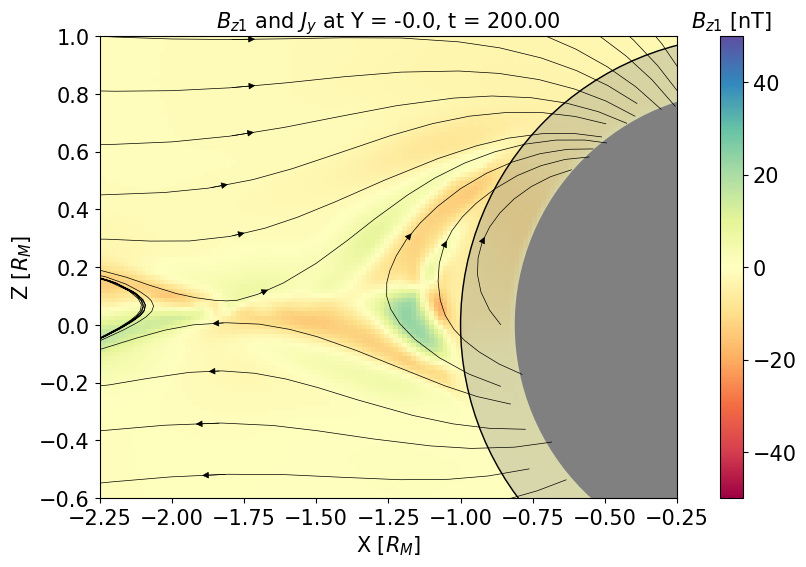

Saved as /Volumes/My Book Duo/runs/DR_run1/ta-2_plots/MHD_DR_plot2_y-0.0_200.00.png
Plotting t = 201.0


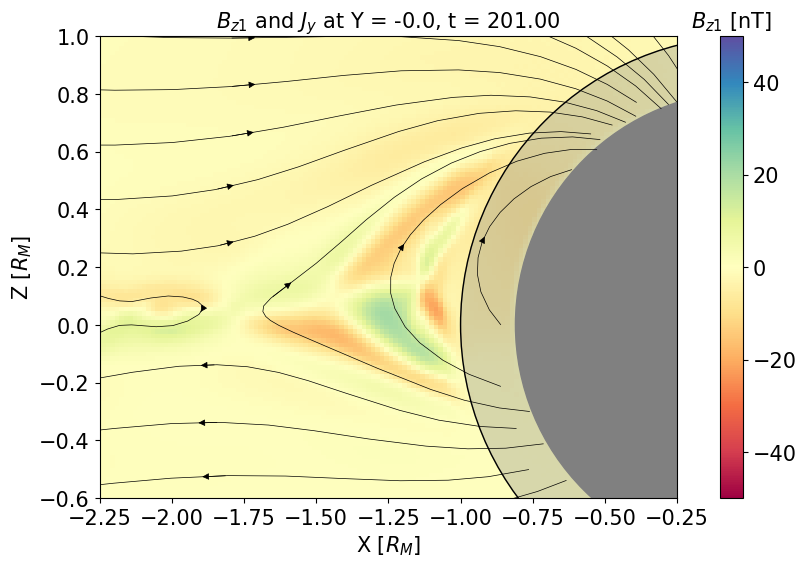

Saved as /Volumes/My Book Duo/runs/DR_run1/ta-2_plots/MHD_DR_plot2_y-0.0_201.00.png
Plotting t = 202.0


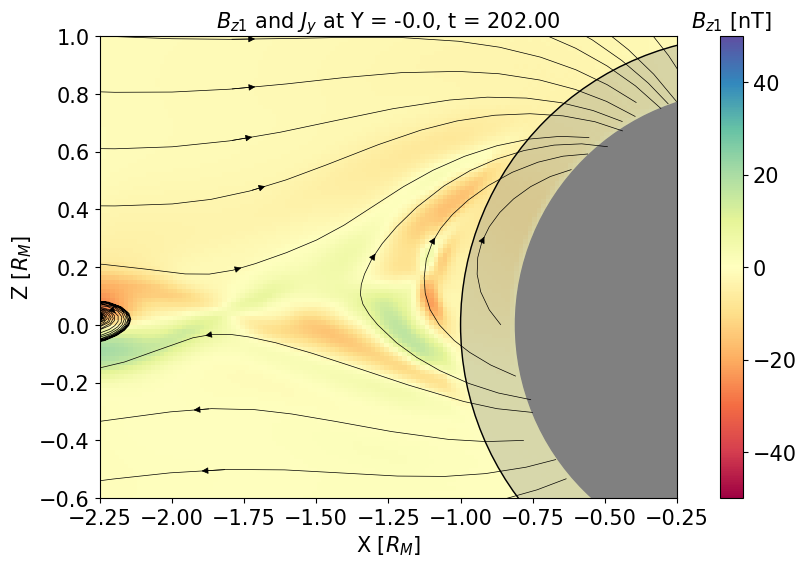

Saved as /Volumes/My Book Duo/runs/DR_run1/ta-2_plots/MHD_DR_plot2_y-0.0_202.00.png
Plotting t = 203.0


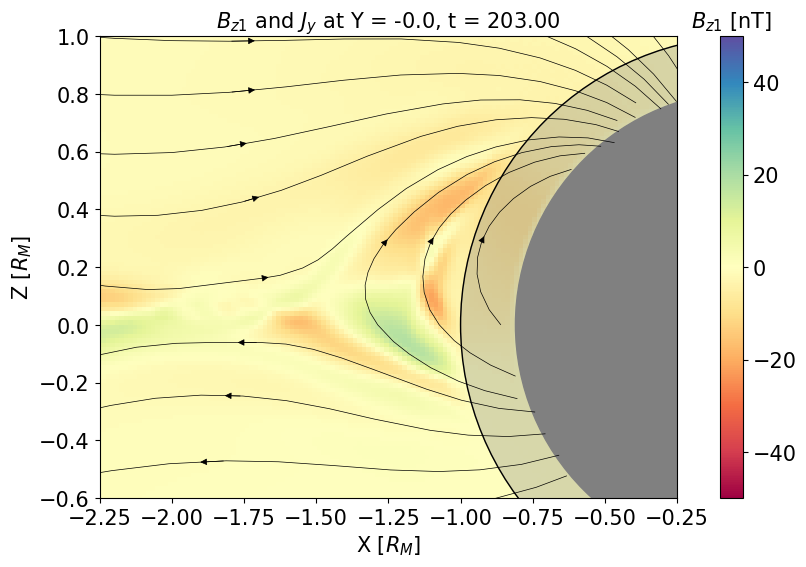

Saved as /Volumes/My Book Duo/runs/DR_run1/ta-2_plots/MHD_DR_plot2_y-0.0_203.00.png


In [269]:
#### MHD ONLY PLOTTING ####
MHD_files_3D = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*numpy\_t\_...\...",read_time = True,reduce = True)
MHD_files_cs = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*csdata\_t\_...\...",read_time = True,reduce = True)

# Begin iteration loop
iter = 0
print("Plotmode:",plot_preset)
for time_str in list(MHD_files_3D.keys()): 
    time = float(time_str)
    print("Plotting t =",time)

    # Read in 3D MHD data
    my_file = str(MHD_files_3D[time_str])
    with open(dir+my_file, 'rb') as f:
        MHD_data_3D = pickle.load(f)
    # Read in cs MHD data
    #my_file = str(MHD_files_cs[MHD_time])
    #with open(dir+my_file, 'rb') as f:
    #    MHD_data_cs = pickle.load(f)

    if plot_preset == "MHD_DR_plot1":

        # Declare fig.
        fig, ax = plt.subplots(nrows=1,figsize=(11,6))
        
        # Plotting hyperparamters
        yplane = -0.2

        # Precomputations
        yi = np.where(Y[:,0,0]>yplane)[0][0]

        # Unpack data
        X = MHD_data_3D['X']
        Y = MHD_data_3D['Y']
        Z = MHD_data_3D['Z']
        Bx = MHD_data_3D['B_x [[]nT[]]']
        By = MHD_data_3D['B_y [[]nT[]]']
        Bz = MHD_data_3D['B_z [[]nT[]]']
        Jy = MHD_data_3D['J_y [[]`mA/m^2[]]']
        P = MHD_data_3D['P [[]nPa[]]']
        Bxdip = Bx_dip(X,Y,Z)
        Bzdip = Bz_dip(X,Y,Z)

        # Derived quantities
        Bz1 = Bz-Bzdip

        # Mask things out
        mask = X**2+Y**2+Z**2<0.8**2
        Bz1[mask]=np.nan
        
        # Show Bz1 and Jy
        Bz1_plot = ax.imshow(Bz1[yi,:,:].T,origin='lower',extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)],vmin=-50,vmax=50,cmap='Spectral')
        Jy_plot = ax.contour(X[yi,:,:],Z[yi,:,:],Jy[yi,:,:],[-0.01,0.01],linewidths = 1.5,colors=['red','blue'])

        # Show pressure
        P_plot = ax.contour(X[yi,:,:],Z[yi,:,:],P[yi,:,:],np.arange(1,22,2),colors='grey',linewidths=0.75)

        # Show streamlines, first fixing up the grid to uniform spacing
        X_axis = np.linspace(np.min(X),np.max(X),len(X[yi,:,0]))
        Z_axis = np.linspace(np.min(Z),np.max(Z),len(X[yi,0,:]))
        X_fixed, Z_fixed = np.meshgrid(X_axis,Z_axis)
        X_fixed = X_fixed
        Z_fixed = Z_fixed
        B_stream = ax.streamplot(X_fixed,Z_fixed,Bx[yi,:,:].T,Bz[yi,:,:].T,
                                 broken_streamlines=False,color='black',linewidth=0.5,density=0.5)
        #Bdip_stream = ax.streamplot(X_fixed,Z_fixed,Bxdip[yi,:,:].T,Bzdip[yi,:,:].T,
        #                         broken_streamlines=False,color='black',linewidth=1.5,density=0.5)

        # Add planet
        inner = plt.Circle((0, 0), np.sqrt(0.81**2-yplane**2), color='gray')
        outer = plt.Circle((0, 0), np.sqrt(1-yplane**2), color='grey',alpha = 0.3)
        edge = plt.Circle((0, 0), np.sqrt(1-yplane**2), color='black',fill = False)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(edge)

        # Tidy up axes
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Z [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.set_xlim(xlims_zoom)
        ax.set_ylim(zlims_zoom)
        ax.set_title(str("$B_{z1}$ and $J_y$ at Y = "+str(round(yplane,1))+", t = "+time_str),fontsize=15)

        # Colorbar
        clb1 = fig.colorbar(Bz1_plot,ax=ax)
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=15)
        #fig.colorbar(Jy_plot,ax=ax)

        plt.show()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"y"+str(round(yplane,1))+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"y"+str(round(yplane,1))+"_"+time_str+'.png'))
        plt.close(fig)

    if plot_preset == "MHD_DR_plot2":

        # Declare fig.
        fig, ax = plt.subplots(nrows=1,figsize=(11,6))
        
        # Plotting hyperparamters
        yplane = -0.0

        # Precomputations
        yi = np.where(Y[:,0,0]>yplane)[0][0]

        # Unpack data
        X = MHD_data_3D['X']
        Y = MHD_data_3D['Y']
        Z = MHD_data_3D['Z']
        Bx = MHD_data_3D['B_x [[]nT[]]']
        By = MHD_data_3D['B_y [[]nT[]]']
        Bz = MHD_data_3D['B_z [[]nT[]]']
        Jy = MHD_data_3D['J_y [[]`mA/m^2[]]']
        P = MHD_data_3D['P [[]nPa[]]']
        Bxdip = Bx_dip(X,Y,Z)
        Bydip = By_dip(X,Y,Z)
        Bzdip = Bz_dip(X,Y,Z)

        # Derived quantities
        By1 = By-Bydip

        # Mask things out
        mask = X**2+Y**2+Z**2<0.8**2
        By1[mask]=np.nan
        
        # Show Bz1 and Jy
        By1_plot = ax.imshow(By1[yi,:,:].T,origin='lower',extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)],vmin=-50,vmax=50,cmap='Spectral')
        #Jy_plot = ax.contour(X[yi,:,:],Z[yi,:,:],Jy[yi,:,:],[-0.01,0.01],linewidths = 1.5,colors=['red','blue'])

        # Show pressure
        #P_plot = ax.contour(X[yi,:,:],Z[yi,:,:],P[yi,:,:],np.arange(1,22,2),colors='grey',linewidths=0.75)

        # Show streamlines, first fixing up the grid to uniform spacing
        X_axis = np.linspace(np.min(X),np.max(X),len(X[yi,:,0]))
        Z_axis = np.linspace(np.min(Z),np.max(Z),len(X[yi,0,:]))
        X_fixed, Z_fixed = np.meshgrid(X_axis,Z_axis)
        X_fixed = X_fixed
        Z_fixed = Z_fixed
        B_stream = ax.streamplot(X_fixed,Z_fixed,Bx[yi,:,:].T,Bz[yi,:,:].T,
                                 broken_streamlines=False,color='black',linewidth=0.5,density=0.5)
        #Bdip_stream = ax.streamplot(X_fixed,Z_fixed,Bxdip[yi,:,:].T,Bzdip[yi,:,:].T,
        #                         broken_streamlines=False,color='black',linewidth=1.5,density=0.5)

        # Add planet
        inner = plt.Circle((0, 0), np.sqrt(0.81**2-yplane**2), color='gray')
        outer = plt.Circle((0, 0), np.sqrt(1-yplane**2), color='grey',alpha = 0.3)
        edge = plt.Circle((0, 0), np.sqrt(1-yplane**2), color='black',fill = False)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(edge)

        # Tidy up axes
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Z [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.set_xlim(xlims_zoom)
        ax.set_ylim(zlims_zoom)
        ax.set_title(str("$B_{z1}$ and $J_y$ at Y = "+str(round(yplane,1))+", t = "+time_str),fontsize=15)

        # Colorbar
        clb1 = fig.colorbar(Bz1_plot,ax=ax)
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=15)
        #fig.colorbar(Jy_plot,ax=ax)

        plt.show()
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"y"+str(round(yplane,1))+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"y"+str(round(yplane,1))+"_"+time_str+'.png'))
        plt.close(fig)
        

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_78906/3456763552.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.sqrt(Bx**2+Bz**2))[yi,:,:].T,origin='lower',vmin=3,vmax=7,cmap="Spectral",extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])


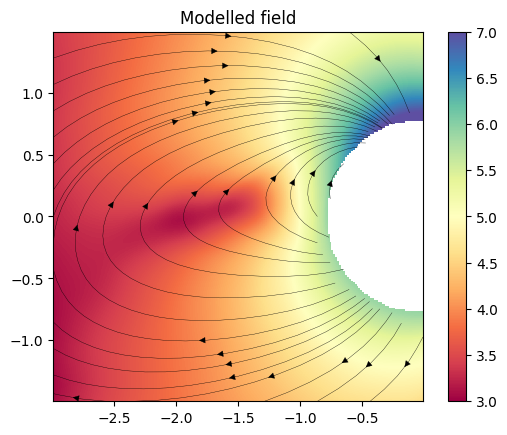

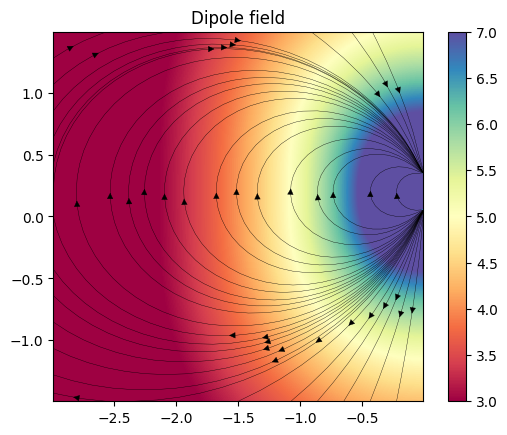

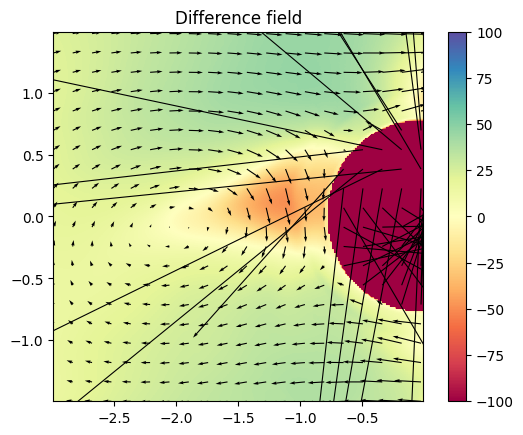

In [242]:
plt.imshow(np.log(np.sqrt(Bx**2+Bz**2))[yi,:,:].T,origin='lower',vmin=3,vmax=7,cmap="Spectral",extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])
plt.colorbar()
B_stream = plt.streamplot(X_fixed,Z_fixed,Bx[yi,:,:].T,Bz[yi,:,:].T,
                                 broken_streamlines=False,color='black',linewidth=0.25,density=0.5)
plt.title("Modelled field")
plt.show()

plt.imshow(np.log(np.sqrt(Bxdip**2+Bzdip**2))[yi,:,:].T,origin='lower',vmin=3,vmax=7,cmap="Spectral",extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])
plt.colorbar()
B_stream = plt.streamplot(X_fixed,Z_fixed,Bxdip[yi,:,:].T,Bzdip[yi,:,:].T,
                                 broken_streamlines=False,color='black',linewidth=0.25,density=0.5)
plt.title("Dipole field")
plt.show()

plt.imshow((np.sqrt(Bx**2+Bz**2) - np.sqrt(Bxdip**2+Bzdip**2))[yi,:,:].T,origin='lower',vmin=-100,vmax=100,cmap="Spectral",extent = [np.min(X),np.max(X),np.min(Z),np.max(Z)])
plt.colorbar()
skip = 10
B_stream = plt.quiver(X_fixed[::skip,::skip],Z_fixed[::skip,::skip],(Bx-Bxdip)[yi,::skip,::skip].T,(Bz-Bzdip)[yi,::skip,::skip].T,scale=1e3)
plt.title("Difference field")
plt.show()

In [ ]:


#### CONVERGENCE TESTING #####
'''
This routine uses 3d tec data (in 3d__var*.plt format) to show the convergence of the simulation towards steady state
'''
#### USER INPUT ####
dir = "/Volumes/My Book Duo/runs/nightside_v5_run3/convergence_files/"
start_time = 60
t_bound = [60,250]
dt = 10
convergence_vars = ["Rho","U_x","B_z","P"]
convergence_indices = [4,5,13,14] # Needs to be determined by looking manually at the tecplot file
port=7605
#### END USER INPUT ####

#### BEGIN PLOTTING ####
#Retrieve the file names
convergence_files = get_files(dir, start_time, [0,0], dt, key="3d\_\_var.*.plt", read_time = False, reduce = False)
convergence_vals = np.empty((len(convergence_files),len(convergence_vars)))

# Open each file in tecplot
for it,file in enumerate(convergence_files.values()):
    mypath = dir+file
    dataset = read_dataset(mypath,port)
    frame = tp.active_frame()

    # Iterate through the chosen variables to compute
    for ivar,var in enumerate(convergence_indices):
        # Integrate
        tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
        command=str("Integrate VariableOption='Average' XOrigin=0 YOrigin=0 ZOrigin=0 ScalarVar="+str(var)+" Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' IRange={MIN =1 MAX = 0 SKIP = 1} JRange={MIN =1 MAX = 0 SKIP = 1} KRange={MIN =1 MAX = 0 SKIP = 1} PlotResults='F' PlotAs='Result' TimeMin=0 TimeMax=0"))
        # Save to array
        aux_data = frame.aux_data.as_dict()
        convergence_vals[it,ivar] = float(list(aux_data.values())[0])

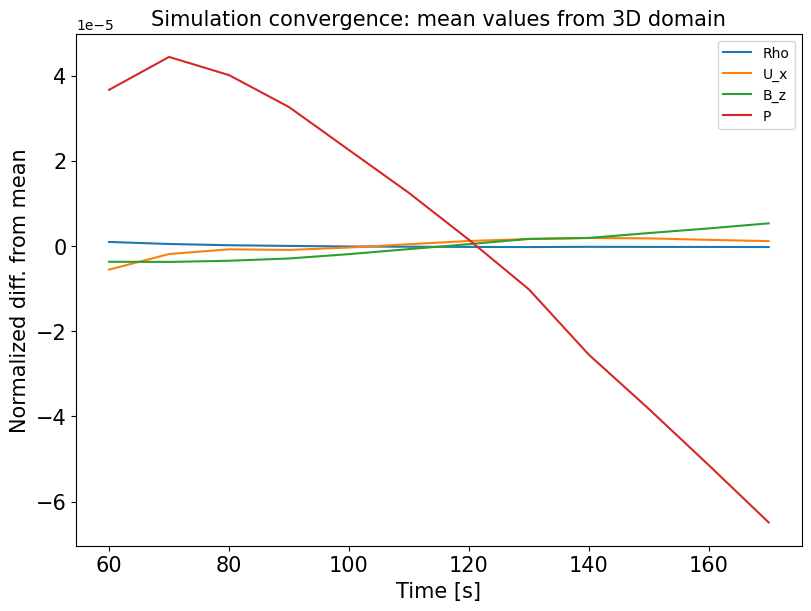

In [774]:
# Show result
fig = plt.figure(figsize=(8,6), constrained_layout=True)
ax = fig.add_subplot(111)#, projection="3d",computed_zorder=False)

for ivar,var in enumerate(convergence_vars):
    ax.plot(list(convergence_files.keys()), (convergence_vals[:,ivar]-np.mean(convergence_vals[:,ivar]))/np.abs(np.mean(convergence_vals[:,ivar])),label=var)
ax.legend()
ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Normalized diff. from mean",fontsize=15)
ax.set_title("Simulation convergence: mean values from 3D domain",fontsize=15)
ax.tick_params(axis='both',labelsize=15)

fig.savefig(str(dir+'convergence.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)


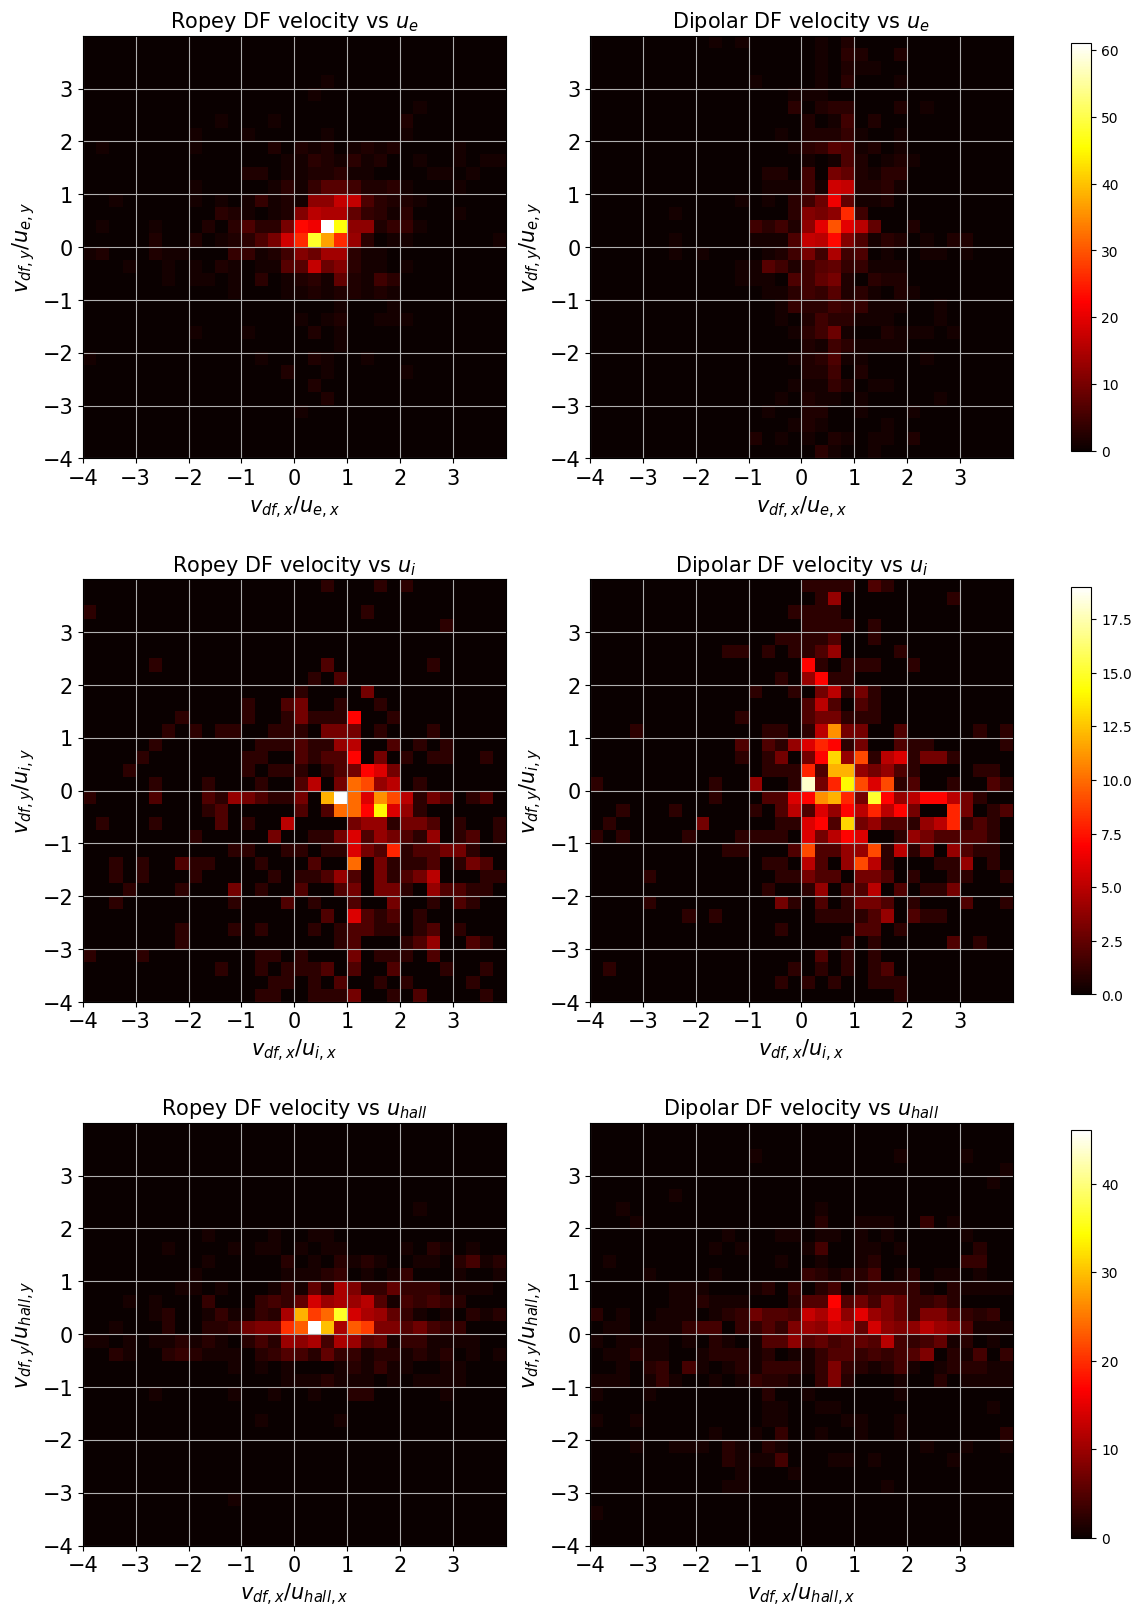

In [6]:
##### POST-TRACKING ANALYSIS SCRIPTS #####
'''
The following section is for producing plots using the 'df_data' pickle files produced by running the df_tracker routines in 3D_plotting. 
Many of these plots are updated versions of those originally written in "fast_plot".
'''

# USER INPUT
#dir = "/Volumes/My Book Duo/runs/nightside_v5_run3/alldata/"
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v5_run3/alldata/"
plot_preset = "df_velocity_distribution"
xlims = [-4,-0.5]
ylims = [-1.2,1.2]
min_df_length = 20# time steps

'''
Presets:
df_number_flux_heatmap
df_streamplot
df_velocity_distribution
df_size_distribution
df_magnetic_topology
df_forces
df_force_distribution
'''

# END USER INPUT

# BEGIN PLOTTING
with open(dir+"df_data", 'rb') as f:
    df_data = pickle.load(f)

if plot_preset == "df_number_flux_heatmap":
    # Create figure
    fig, axs = plt.subplots(ncols = 2, figsize=(20,5))
    # Declare the size of the heatmap bins
    binsize = 0.1 # R_M
    # Create the arrays to store the data
    x_axis = np.arange(xlims[0],xlims[1]+binsize,binsize)
    y_axis = np.arange(ylims[0],ylims[1]+binsize,binsize)
    flux_heatmap = np.zeros((len(y_axis),len(x_axis)))
    number_heatmap = np.zeros_like(flux_heatmap)
    vx_heatmap = np.zeros_like(flux_heatmap)
    vy_heatmap = np.zeros_like(flux_heatmap)
    # Record the start and end time
    min_time = 1e5
    max_time = 0
    # Iterate through all the dfs
    for key, value in df_data.items():
        already_visited = np.zeros_like(flux_heatmap, dtype="bool")
        if len(value)>min_df_length:
             # Create temporary df
            temp = value.copy()
            window_size = 5  # Should be a positive odd number
            poly_order = 2   # Polynomial order
            dt = 0.05 # Timestep size
            # Compute smooothed trajectory
            temp['X_smooth'] = savgol_filter(temp['X'], window_size, poly_order)
            temp['Y_smooth'] = savgol_filter(temp['Y'], window_size, poly_order)
            temp['Z_smooth'] = savgol_filter(temp['Z'], window_size, poly_order)
            # Compute velocity components from smoothed data
            temp['udfx'] = np.gradient(temp['X_smooth'], dt) * R_M/1e3
            temp['udfy'] = np.gradient(temp['Y_smooth'], dt) * R_M/1e3
            temp['udfz'] = np.gradient(temp['Z_smooth'], dt) * R_M/1e3
            # Iterate through each time step
            for it, time in enumerate(value['time'].to_numpy()):
                # Find which cell this DF is in at this time
                ix = np.where(temp["X"][it] < x_axis)[0][0]
                iy = np.where(temp["Y"][it] < y_axis)[0][0]
                if not already_visited[iy,ix]:
                    # Add its number and flux contribution
                    flux_heatmap[iy,ix] += temp["Bz"][it]
                    number_heatmap[iy,ix] += 1
                    # Save its velocity to the average mesh
                    vx_heatmap[iy,ix] += temp['udfx'][it]
                    vy_heatmap[iy,ix] += temp['udfy'][it]
                    # Make note that this df has now visited this cell
                already_visited[iy,ix] = True
                # Potentially update the timing
                if time>max_time:
                    max_time=time
                if time<min_time:
                    min_time=time
        # Show the trajectory
        #for ax in axs:
            #ax.plot(value["X"].to_numpy(),value["Y"].to_numpy(),color='red',lw=0.2,alpha=0.5)

    # Compute total time of data
    total_time = (max_time-min_time)/60 #mins

    # Average out the velocity heatmaps
    vx_heatmap = vx_heatmap / number_heatmap
    vy_heatmap = vy_heatmap / number_heatmap
    
    # Smooth results
    sigma = 1
    #flux_heatmap = gaussian_filter(flux_heatmap,sigma = sigma)
    #number_heatmap = gaussian_filter(number_heatmap,sigma = sigma)
    
    # Show residence heatmaps
    interpolation = 'none'
    number_heatmap_plot = axs[0].imshow(number_heatmap/total_time,origin='lower',extent=[*xlims,*ylims],interpolation=interpolation)
    flux_heatmap_plot = axs[1].imshow(flux_heatmap,origin='lower',extent=[*xlims,*ylims],interpolation=interpolation,cmap='plasma')

    # Show average velocities
    #axs[0].quiver(*np.meshgrid(x_axis,y_axis),vx_heatmap,vy_heatmap,color='white',scale=1e5)
    #axs[0].streamplot(*np.meshgrid(x_axis,y_axis),vx_heatmap,vy_heatmap,color='white',broken_streamlines=False,density=1,linewidth=0.5)
    #axs[0].contourf(*np.meshgrid(x_axis,y_axis),vx_heatmap,[0,1e5],colors='red',alpha=0.5)

    # Beautify
    for ax in axs:
        # Add planet
        ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
        ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
        # Set labels
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        # Add grid
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        # set axes limits
        ax.set_xlim(*xlims)
        ax.set_ylim(*ylims)
    
    # Add colorbar
    clb1 = fig.colorbar(number_heatmap_plot, ax=axs[0])
    clb1.ax.tick_params(labelsize=15)
    clb1.ax.set_title('DFs per min',fontsize=15)
    clb2 = fig.colorbar(flux_heatmap_plot, ax=axs[1])
    clb2.ax.tick_params(labelsize=15)
    clb2.ax.set_title('DF $B_z$ flux',fontsize=15)

    # TEMP
    heatmap_plot_data = number_heatmap/total_time

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+'.png'),bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

if plot_preset == "df_streamplot":
    # Create figure
    fig, ax = plt.subplots(ncols = 1, figsize=(8,5))
    # Declare the size of the heatmap bins
    binsize = 0.1 # R_M
    # Create the arrays to store the data
    x_axis = np.arange(xlims[0],xlims[1]+binsize,binsize)
    y_axis = np.arange(ylims[0],ylims[1]+binsize,binsize)
    vx_heatmap = np.zeros((len(y_axis),len(x_axis)))
    vy_heatmap = np.zeros_like(vx_heatmap)
    number_heatmap = np.zeros_like(vx_heatmap) # This records total visits to each cell
    count_heatmap = np.zeros_like(vx_heatmap) # This records how many DFs visit a cell, avoiding double counting
    flux_heatmap = np.zeros_like(vx_heatmap)
    my_dict = {}
    # Record the start and end time
    min_time = 1e5
    max_time = 0
    # Iterate through all the dfs
    for key, value in df_data.items():
        already_visited = np.zeros_like(flux_heatmap, dtype="bool")
        if len(value)>min_df_length and np.mean(value["X"].diff())>0 and value["X"][0]>-2.5:
             # Create temporary df
            temp = value.copy()
           # Choose the order of the spline
            k = 3 # cubic spline
            # Choose interior knots, you can use np.linspace for uniformly distributed knots
            knots = np.linspace(value['time'].min(), value['time'].max(), 4)[1:-1]
            # Fit splines to each dimension
            spline_x = LSQUnivariateSpline(value['time'], temp['X'], knots, k=k)
            spline_y = LSQUnivariateSpline(value['time'], temp['Y'], knots, k=k)
            spline_z = LSQUnivariateSpline(value['time'], temp['Z'], knots, k=k)
            # Evaluate the splines over a fine grid
            temp['X_smooth'] = spline_x(value['time'])
            temp['Y_smooth'] = spline_y(value['time'])
            temp['Z_smooth'] = spline_z(value['time'])
            # Compute velocity components from smoothed data
            temp['udfx'] = np.gradient(temp['X_smooth'], dt) * R_M/1e3
            temp['udfy'] = np.gradient(temp['Y_smooth'], dt) * R_M/1e3
            temp['udfz'] = np.gradient(temp['Z_smooth'], dt) * R_M/1e3
            # Save data
            my_dict[key] = temp
            # Iterate through each time step
            for it, time in enumerate(value['time'].to_numpy()):
                # Find which cell this DF is in at this time
                ix = np.where(temp["X_smooth"][it] < x_axis)[0][0]
                iy = np.where(temp["Y_smooth"][it] < y_axis)[0][0]
                # Save its velocity to the average mesh
                vx_heatmap[iy,ix] += temp['udfx'][it]
                #print(vx_heatmap[iy,ix],"(indices:",iy,ix,"), added:",temp['udfx'][it])
                vy_heatmap[iy,ix] += temp['udfy'][it]
                # Add to the counter for this cell
                number_heatmap[iy,ix] += 1
                # Save the flux content of the DF
                flux_heatmap[iy,ix] += value["Bz"][it]*1e-9*value["area"][it]*(R_M)**2 * 1e-6 #[MWb]
                # Add to the counter of DFs visiting this cell
                if not already_visited[iy,ix]:
                    count_heatmap[iy,ix] += 1
                    already_visited[iy,ix]=True
                # Potentially update the timing
                if time>max_time:
                    max_time=time
                if time<min_time:
                    min_time=time

    # Concatenate into one df
    my_df = pd.concat(my_dict.values(), axis=0)
    my_df.reset_index(drop=True, inplace=True)

    # Compute total time of data
    total_time = (max_time-min_time)/60 #mins

    # Average out the velocity heatmaps
    vx_heatmap = vx_heatmap / number_heatmap
    vy_heatmap = vy_heatmap / number_heatmap    

    # Fill in nans where we have no data
    # Mask of valid (non-NaN) values
    valid_mask = ~np.isnan(vx_heatmap)
    # Known locations (x, y) and their corresponding values
    xx,yy = np.meshgrid(x_axis,y_axis)
    known_x = xx[valid_mask]
    known_y = yy[valid_mask]
    known_values_vx = vx_heatmap[valid_mask]
    known_values_vy = vy_heatmap[valid_mask]
    # Locations where we want to interpolate
    unknown_x = xx[np.isnan(vx_heatmap)]
    unknown_y = yy[np.isnan(vx_heatmap)]
    # Interpolation
    interpolated_values_vx = griddata(
        (known_x, known_y),  # Points
        known_values_vx,        # Values at those points
        (unknown_x, unknown_y),  # Points where we want to interpolate
        method='cubic'  # Method of interpolation: 'linear', 'nearest', 'cubic'
    )
    interpolated_values_vy = griddata(
        (known_x, known_y),  # Points
        known_values_vy,        # Values at those points
        (unknown_x, unknown_y),  # Points where we want to interpolate
        method='cubic'  # Method of interpolation: 'linear', 'nearest', 'cubic'
    )
    # Fill the NaN values with interpolated data
    vx_heatmap[np.isnan(vx_heatmap)] = interpolated_values_vx
    vy_heatmap[np.isnan(vy_heatmap)] = interpolated_values_vy

    # Smooth quantities
    sigma = 1
    #vx_heatmap = gaussian_filter(vx_heatmap,sigma = sigma)
    #vy_heatmap = gaussian_filter(vy_heatmap,sigma = sigma)
    #flux_heatmap = gaussian_filter(flux_heatmap,sigma = sigma)

    # Show flux heatmap
    number_heatmap_plot = ax.imshow(count_heatmap/total_time,origin='lower',extent=[*xlims,*ylims],interpolation='none',cmap='plasma')

    # Show streamplot
    streamplot = ax.streamplot(*np.meshgrid(x_axis,y_axis),vx_heatmap,vy_heatmap,color='white',broken_streamlines=True,
                               density=1,linewidth=5*np.sqrt(vx_heatmap**2+vy_heatmap**2)/np.nanmax(np.sqrt(vx_heatmap**2+vy_heatmap**2)))

    # Beautify
    # Add planet
    ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
    ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
    # Set labels
    ax.set_xlabel("X [$R_M$]",fontsize=15)
    ax.set_ylabel("Y [$R_M$]",fontsize=15)
    ax.tick_params(axis='both',labelsize=15)
    # Add grid
    x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    ax.set_xticks(x_major_ticks)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    # set axes limits
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_aspect(1)
    
    # Add colorbar
    #clb1 = fig.colorbar(flux_plot, ax=ax)
    #clb1.ax.tick_params(labelsize=15)
    #clb1.ax.set_title('Total DF flux [MWb]',fontsize=15)
    clb1 = fig.colorbar(number_heatmap_plot, ax=ax)
    clb1.ax.tick_params(labelsize=15)
    clb1.ax.set_title('DFs per min',fontsize=15)

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+'.png'),bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

if plot_preset == "df_velocity_distribution":
    # Create an array to save data from "long enough" dfs
    my_dict_closed = {}
    my_dict_ropey = {}
    # Compute DF motional velocity
    for key, value in df_data.items():
        if len(value)>min_df_length and np.mean(value["X"].diff())>0 and value["X"][0]>-2.5:
            # Create temporary df
            temp = value.copy()
            '''
            # Apply Savitzky-Golay filter for smoothing
            window_size = 7  # Should be a positive odd number
            poly_order = 2   # Polynomial order
            temp['X_smooth'] = savgol_filter(temp['X'], window_size, poly_order)
            temp['Y_smooth'] = savgol_filter(temp['Y'], window_size, poly_order)
            temp['Z_smooth'] = savgol_filter(temp['Z'], window_size, poly_order)
            '''
            dt = 0.05 # Timestep size
            # Choose the order of the spline
            k = 3 # cubic spline
            # Choose interior knots, you can use np.linspace for uniformly distributed knots
            knots = np.linspace(value['time'].min(), value['time'].max(), 4)[1:-1]
            # Fit splines to each dimension
            spline_x = LSQUnivariateSpline(value['time'], temp['X'], knots, k=k)
            spline_y = LSQUnivariateSpline(value['time'], temp['Y'], knots, k=k)
            spline_z = LSQUnivariateSpline(value['time'], temp['Z'], knots, k=k)
            # Evaluate the splines over a fine grid
            temp['X_smooth'] = spline_x(value['time'])
            temp['Y_smooth'] = spline_y(value['time'])
            temp['Z_smooth'] = spline_z(value['time'])
            # Compute velocity components from smoothed data
            temp['udfx'] = np.gradient(temp['X_smooth'], dt) * R_M/1e3
            temp['udfy'] = np.gradient(temp['Y_smooth'], dt) * R_M/1e3
            temp['udfz'] = np.gradient(temp['Z_smooth'], dt) * R_M/1e3
            # Save filtered data
            my_dict_ropey[key] = temp[temp['frac_ropey'] > 0.5]
            my_dict_closed[key] = temp[temp['frac_ropey'] <= 0.5]
            # DEBUG plot
            #plt.plot(temp["X"],temp["Y"],color="black")
            #plt.plot(temp["X_smooth"],temp["Y_smooth"],color="red")
    #plt.xlim(-3,-1.2)
    #plt.ylim(*ylims)
    #plt.show()
    
    # Create figure
    fig, axs = plt.subplots(ncols = 2,nrows=3, figsize=(15,20))
    # Reformat the df_data object into a single dataframe
    my_df_ropey = pd.concat(my_dict_ropey.values(), axis=0)
    my_df_ropey.reset_index(drop=True, inplace=True)
    my_df_closed = pd.concat(my_dict_closed.values(), axis=0)
    my_df_closed.reset_index(drop=True, inplace=True)

    # Compute exb drift velocity (crude)
    #v_exb_x = (my_df["E_convy"]*my_df["Bz"]-my_df["E_convz"]*my_df["By"])/(my_df["Bx"]**2+my_df["By"]**2+my_df["Bz"]**2)/1e-9/1e3 #[km/s]
    #v_exb_y = (my_df["E_convz"]*my_df["Bx"]-my_df["E_convx"]*my_df["Bz"])/(my_df["Bx"]**2+my_df["By"]**2+my_df["Bz"]**2)/1e-9/1e3
    
    # Bin the data
    num_bins = 32
    x_range = (-4,4)
    y_range = (-4,4)
    #u_hallx = my_df['Jx']/(e*my_df['n'])/1e3 # Derived from gombosi 1998, p73. [km/s]
    #u_hally = my_df['Jy']/(e*my_df['n'])/1e3
    #hist1, xedges1, yedges1 = np.histogram2d(my_df["udfx"]/my_df["uex"], my_df["udfy"]/my_df["uey"], bins=num_bins, range=[x_range, y_range])
    #hist2, xedges2, yedges2 = np.histogram2d(my_df["udfx"]/my_df["uix"], my_df["udfy"]/my_df["uiy"], bins=num_bins, range=[x_range, y_range])
    #hist3, xedges3, yedges3 = np.histogram2d(-my_df["udfx"]/my_df['u_hallx'], -my_df["udfy"]/my_df['u_hally'], bins=num_bins, range=[x_range, y_range])
    #hist4, xedges4, yedges4 = np.histogram2d(my_df["udfx"]/(my_df["uix"]-my_df['u_hallx']), my_df["udfy"]/(my_df["uiy"]-my_df['u_hally']), bins=num_bins, range=[x_range, y_range])
    #hist5, xedges5, yedges5 = np.histogram2d(my_df["udfx"]/my_df["v_exb_x"], my_df["udfy"]/my_df["v_exb_y"], bins=num_bins, range=[x_range, y_range])
    #hist6, xedges6, yedges6 = np.histogram2d(my_df["udfx"]/my_df["v_exb_x"], my_df["udfy"]/my_df["v_exb_y"], bins=num_bins, range=[x_range, y_range])

    hist1, xedges1, yedges1 = np.histogram2d(my_df_ropey["udfx"]/my_df_ropey["uex"], my_df_ropey["udfy"]/my_df_ropey["uey"], bins=num_bins, range=[x_range, y_range])
    hist2, xedges2, yedges2 = np.histogram2d(my_df_closed["udfx"]/my_df_closed["uex"], my_df_closed["udfy"]/my_df_closed["uey"], bins=num_bins, range=[x_range, y_range])
    hist3, xedges3, yedges3 = np.histogram2d(my_df_ropey["udfx"]/my_df_ropey["uix"], my_df_ropey["udfy"]/my_df_ropey["uiy"], bins=num_bins, range=[x_range, y_range])
    hist4, xedges4, yedges4 = np.histogram2d(my_df_closed["udfx"]/my_df_closed["uix"], my_df_closed["udfy"]/my_df_closed["uiy"], bins=num_bins, range=[x_range, y_range])
    hist5, xedges5, yedges5 = np.histogram2d(-my_df_ropey["udfx"]/my_df_ropey['u_hallx'], -my_df_ropey["udfy"]/my_df_ropey['u_hally'], bins=num_bins, range=[x_range, y_range])
    hist6, xedges6, yedges6 = np.histogram2d(-my_df_closed["udfx"]/my_df_closed['u_hallx'], -my_df_closed["udfy"]/my_df_closed['u_hally'], bins=num_bins, range=[x_range, y_range])
    
    # Smooth
    sigma = 0.5
    #hist1 = gaussian_filter(hist1,sigma=sigma)
    #hist2 = gaussian_filter(hist2,sigma=sigma)
    #hist3 = gaussian_filter(hist3,sigma=sigma)
    #hist4 = gaussian_filter(hist4,sigma=sigma)
    #hist5 = gaussian_filter(hist5,sigma=sigma)
    #hist6 = gaussian_filter(hist6,sigma=sigma)

    # Show heatmpas
    interpolation = 'none'
    vmax0 = np.max([np.max(hist1),np.max(hist2)])
    vmax1 = np.max([np.max(hist3),np.max(hist4)])
    vmax2 = np.max([np.max(hist5),np.max(hist6)])
    vmin = 0
    norm = SymLogNorm(linthresh=1, linscale=1, vmin=0, vmax=vmax0, base=10)
    hist1_plot = axs[0,0].imshow(hist1.T, origin='lower', cmap='hot', extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],vmin=vmin,vmax=vmax0, interpolation = interpolation)
    hist2_plot = axs[0,1].imshow(hist2.T, origin='lower', cmap='hot', extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],vmin=vmin,vmax=vmax0, interpolation = interpolation)
    hist3_plot = axs[1,0].imshow(hist3.T, origin='lower', cmap='hot', extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]],vmin=vmin,vmax=vmax1, interpolation = interpolation)
    hist4_plot = axs[1,1].imshow(hist4.T, origin='lower', cmap='hot', extent=[xedges4[0], xedges4[-1], yedges4[0], yedges4[-1]],vmin=vmin,vmax=vmax1, interpolation = interpolation)
    hist5_plot = axs[2,0].imshow(hist5.T, origin='lower', cmap='hot', extent=[xedges5[0], xedges5[-1], yedges5[0], yedges5[-1]],vmin=vmin,vmax=vmax2, interpolation = interpolation)
    hist6_plot = axs[2,1].imshow(hist6.T, origin='lower', cmap='hot', extent=[xedges6[0], xedges6[-1], yedges6[0], yedges6[-1]],vmin=vmin,vmax=vmax2, interpolation = interpolation)
    
    # Add colorbar
    clb0 = fig.colorbar(hist1_plot, ax=axs[0,:],shrink=0.9)
    clb1 = fig.colorbar(hist3_plot, ax=axs[1,:],shrink=0.9)
    clb2 = fig.colorbar(hist5_plot, ax=axs[2,:],shrink=0.9)
    for ax in axs.ravel():
        # Add colorbar
        #clb1 = fig.colorbar(hist1_plot, ax=ax)
        # Axes limits
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        # Grid
        ax.grid()
        ax.set_xticks(np.arange(*x_range, 1))
        ax.set_yticks(np.arange(*y_range, 1))
        # Axes labels
        ax.tick_params(axis='both',labelsize=15)
    axs[0,0].set_xlabel("$v_{df,x}/u_{e,x}$",fontsize=15)
    axs[0,0].set_ylabel("$v_{df,y}/u_{e,y}$",fontsize=15)
    axs[0,1].set_xlabel("$v_{df,x}/u_{e,x}$",fontsize=15)
    axs[0,1].set_ylabel("$v_{df,y}/u_{e,y}$",fontsize=15)
    axs[0,0].set_title("Ropey DF velocity vs $u_e$",fontsize=15)
    axs[0,1].set_title("Dipolar DF velocity vs $u_e$",fontsize=15)
    axs[1,0].set_xlabel("$v_{df,x}/u_{i,x}$",fontsize=15)
    axs[1,0].set_ylabel("$v_{df,y}/u_{i,y}$",fontsize=15)
    axs[1,1].set_xlabel("$v_{df,x}/u_{i,x}$",fontsize=15)
    axs[1,1].set_ylabel("$v_{df,y}/u_{i,y}$",fontsize=15)
    axs[1,0].set_title("Ropey DF velocity vs $u_i$",fontsize=15)
    axs[1,1].set_title("Dipolar DF velocity vs $u_i$",fontsize=15)
    axs[2,0].set_xlabel("$v_{df,x}/u_{hall,x}$",fontsize=15)
    axs[2,0].set_ylabel("$v_{df,y}/u_{hall,y}$",fontsize=15)
    axs[2,1].set_xlabel("$v_{df,x}/u_{hall,x}$",fontsize=15)
    axs[2,1].set_ylabel("$v_{df,y}/u_{hall,y}$",fontsize=15)
    axs[2,0].set_title("Ropey DF velocity vs $u_{hall}$",fontsize=15)
    axs[2,1].set_title("Dipolar DF velocity vs $u_{hall}$",fontsize=15)


if plot_preset == "df_size_distribution":
    # Create an array to save data from "long enough" dfs
    my_dict = {}
    # Filter out short DFs
    for key, value in df_data.items():
        if len(value)>min_df_length and np.mean(value['frac_closed'])>0.5:
            # Save data
            my_dict[key] = value

    # Declare figure
    fig,axs= plt.subplots(ncols=2,figsize=(17,8))

    # Concatenate into one df
    my_df = pd.concat(my_dict.values(), axis=0)
    my_df.reset_index(drop=True, inplace=True)

    # Plot data and best fit
    def plot_with_fit(ax, x, y, label):
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        # Calculate line of best fit
        line_fit = slope * np.sort(x) + intercept
        # Plot data
        ax.scatter(x, y, alpha=0.3)
        ax.plot(np.sort(x), line_fit, label=f"{label} fit ($R^2 = {r_value**2:.2f}$)")
        
    x = np.sqrt(my_df['area']/np.pi)
    plot_with_fit(axs[0],x,my_df['r_e'],"$r_e$")
    plot_with_fit(axs[0],x,my_df['r_i'],"$r_i$")
    plot_with_fit(axs[1],x,my_df['d_e'],"$d_e$")
    plot_with_fit(axs[1],x,my_df['d_i'],"$d_i$")
    #axs[0].scatter(x,my_df['r_e'],alpha=0.3,label="e-")
    #axs[0].scatter(x,my_df['r_i'],alpha=0.3,label="h+")
    #axs[1].scatter(x,my_df['d_e'],alpha=0.3,label="e-")
    #axs[1].scatter(x,my_df['d_i']*10,alpha=0.3,label="h+")

    # Tidy up
    for axi in axs:
        #axi.set_xlim(-4,-1)
        axi.set_ylim(1e-3,1)
        axi.set_xlabel("DF size [$R_M$]",fontsize=15)
        #axi.set_xscale("log")
        axi.set_yscale("log")
        axi.legend()
        axi.tick_params(axis='both',labelsize=15)

    # Label
    axs[0].set_ylabel("Lamor radius [$R_M$]",fontsize=15)
    axs[1].set_ylabel("Inertial length [$R_M$]",fontsize=15)


if plot_preset == "df_magnetic_topology":
    # Create figure
    fig,ax = plt.subplots(ncols=1,figsize=(13,8))

    my_dict = {}
    
    for key, value in df_data.items():
        if len(value)>min_df_length:# and np.mean(value["X"].diff())>0 and value["X"][0]>-2.5:
            # Create temporary df
            temp = value.copy()
            '''
            # Apply Savitzky-Golay filter for smoothing
            window_size = 7  # Should be a positive odd number
            poly_order = 2   # Polynomial order
            dt = 0.05 # Timestep size
            temp['X_smooth'] = savgol_filter(temp['X'], window_size, poly_order)
            temp['Y_smooth'] = savgol_filter(temp['Y'], window_size, poly_order)
            temp['Z_smooth'] = savgol_filter(temp['Z'], window_size, poly_order)
            '''
            # Choose the order of the spline
            k = 3 # cubic spline
            # Choose interior knots, you can use np.linspace for uniformly distributed knots
            knots = np.linspace(value['time'].min(), value['time'].max(), 4)[1:-1]
            # Fit splines to each dimension
            spline_x = LSQUnivariateSpline(value['time'], value['X'], knots, k=k)
            spline_y = LSQUnivariateSpline(value['time'], value['Y'], knots, k=k)
            spline_z = LSQUnivariateSpline(value['time'], value['Z'], knots, k=k)
            # Evaluate the splines over a fine grid
            temp['X_smooth'] = spline_x(value['time'])
            temp['Y_smooth'] = spline_y(value['time'])
            temp['Z_smooth'] = spline_z(value['time'])
            z1 = value["frac_closed"]-value["frac_external"]
            z2 = value["frac_ropey"]
            a = (value["Bz"]*value['area'])**0.6*2
            #a = df_data[key]["wake_Jy"]
            # Create a set of line segments so that each segment is colored separately
            points = np.array([temp['X_smooth'], temp['Y_smooth']]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Create a LineCollection for the topology segments
            #cmap = Colormap('PRGn_10_r') .to_mpl()
            cmap = plt.get_cmap('coolwarm_r')#('winter') 
            norm = plt.Normalize(0, 1)
            lc2 = LineCollection(segments, cmap=cmap, norm=norm)
           # Set the values used for colormapping
            lc2.set_array(z2)
    
            # Set the widths
            lc2.set_linewidths(np.array(a))
    
            # Show line segments
            ax.add_collection(lc2)
    
            # Save data
            my_dict[key] = temp

    # Reformat the df_data object into a single dataframe
    my_df = pd.concat(my_dict.values(), axis=0)
    my_df.reset_index(drop=True, inplace=True)

    # Show quivers
    #ue_quiver = ax.quiver(my_df['X_smooth'],my_df['Y_smooth'],my_df['uex'],my_df['uey'],color='green')
    #ui_quiver = ax.quiver(my_df['X_smooth'],my_df['Y_smooth'],my_df['uix'],my_df['uiy'],color='purple')
    #ve_gc_quiver = ax.quiver(my_df['X_smooth'],my_df['Y_smooth'],my_df['ve_gc_x'],my_df['ve_gc_y'])

    # Tidy up plot
    ax.add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax.add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax.tick_params(axis='both',labelsize=15)
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_aspect(1)
    ax.set_xlabel("X [$R_M$]",fontsize=15)
    ax.set_ylabel("Y [$R_M$]",fontsize=15)
    ax.set_title("Field line topology",fontsize=15)
    
    # Colorbar


    cbar1 = plt.colorbar(lc2, ax=ax)   
    cbar1.ax.tick_params(labelsize=15)
    cbar1.set_ticks([0,1])
    cbar1.set_ticklabels(['Unlooped','Looped'],rotation='vertical')
    cbar1.ax.get_yticklabels()[0].set_va('bottom')
    cbar1.ax.get_yticklabels()[1].set_va('top')

if plot_preset == "df_forces":
    # Create figure
    fig, ax = plt.subplots(ncols = 1, figsize=(8,5))
    # Declare the size of the heatmap bins
    binsize = 0.2 # R_M
    # Create the arrays to store the data
    x_axis = np.arange(xlims[0],xlims[1]+binsize,binsize)
    y_axis = np.arange(ylims[0],ylims[1]+binsize,binsize)
    vx_heatmap = np.zeros((len(y_axis),len(x_axis)))
    vy_heatmap = np.zeros_like(vx_heatmap)
    ax_heatmap = np.zeros_like(vx_heatmap) # Records deceleration of DF
    ay_heatmap = np.zeros_like(vx_heatmap)
    Fx_heatmap = np.zeros_like(vx_heatmap) # Records deceleration force from JxB
    Fy_heatmap = np.zeros_like(vx_heatmap)
    gradpx_heatmap = np.zeros_like(vx_heatmap)
    gradpy_heatmap = np.zeros_like(vx_heatmap)
    number_heatmap = np.zeros_like(vx_heatmap) # This records total visits to each cell
    count_heatmap = np.zeros_like(vx_heatmap) # This records how many DFs visit a cell, avoiding double counting
    my_dict = {} # Empty DF to store sorted data

    # Record the start and end time
    min_time = 1e5
    max_time = 0
    # Iterate through all the dfs
    for key, value in df_data.items():
        already_visited = np.zeros_like(flux_heatmap, dtype="bool")
        if len(value)>min_df_length:# and np.mean(value['frac_closed'])>0.5:
             # Create temporary df
            temp = value.copy()
           # Choose the order of the spline
            k = 3 # cubic spline
            dt = 0.05
            # Choose interior knots, you can use np.linspace for uniformly distributed knots
            knots = np.linspace(value['time'].min(), value['time'].max(), 4)[1:-1]
            # Fit splines to each dimension
            spline_x = LSQUnivariateSpline(value['time'], temp['X'], knots, k=k)
            spline_y = LSQUnivariateSpline(value['time'], temp['Y'], knots, k=k)
            spline_z = LSQUnivariateSpline(value['time'], temp['Z'], knots, k=k)
            # Evaluate the splines over a fine grid
            temp['X_smooth'] = spline_x(value['time'])
            temp['Y_smooth'] = spline_y(value['time'])
            temp['Z_smooth'] = spline_z(value['time'])
            # Compute velocity components from smoothed data
            temp['udfx'] = np.gradient(temp['X_smooth'], dt) * R_M/1e3
            temp['udfy'] = np.gradient(temp['Y_smooth'], dt) * R_M/1e3
            temp['udfz'] = np.gradient(temp['Z_smooth'], dt) * R_M/1e3
            # Calculate acceleration by finding the difference of each velocity column and dividing by dt
            temp['az'] = temp['udfz'].diff() / dt
            temp['ay'] = temp['udfy'].diff() / dt
            temp['ax'] = temp['udfx'].diff() / dt
            # Fill NaN (the first row) with the subsequent value
            temp['az'] = temp['az'].bfill()
            temp['ay'] = temp['ay'].bfill()
            temp['ax'] = temp['ax'].bfill()
            # Save data
            my_dict[key] = temp
            # Iterate through each time step
            for it, time in enumerate(value['time'].to_numpy()):
                # Find which cell this DF is in at this time
                ix = np.where(temp["X_smooth"][it] < x_axis)[0][0]
                iy = np.where(temp["Y_smooth"][it] < y_axis)[0][0]
                # Save its velocity to the average mesh
                #vx_heatmap[iy,ix] += temp['udfx'][it]#
                #vy_heatmap[iy,ix] += temp['udfy'][it]
                # Save accelerations
                ax_heatmap[iy,ix] += temp['ax'][it]
                ay_heatmap[iy,ix] += temp['ay'][it]
                # Save forces
                Fx_heatmap[iy,ix] += temp['JxB_x'][it]
                Fy_heatmap[iy,ix] += temp['JxB_y'][it]
                gradpx_heatmap[iy,ix] += temp['gradp_x'][it]
                gradpy_heatmap[iy,ix] += temp['gradp_y'][it]
                # Add to the counter for this cell
                number_heatmap[iy,ix] += 1
                # Save the flux content of the DF
                flux_heatmap[iy,ix] += value["Bz"][it]*1e-9*value["area"][it]*(R_M)**2 * 1e-6 #[MWb]
                # Add to the counter of DFs visiting this cell
                if not already_visited[iy,ix]:
                    count_heatmap[iy,ix] += 1
                    already_visited[iy,ix]=True
                # Potentially update the timing
                if time>max_time:
                    max_time=time
                if time<min_time:
                    min_time=time

    # Reformat the df_data object into a single dataframe
    my_df = pd.concat(my_dict.values(), axis=0)
    my_df.reset_index(drop=True, inplace=True)

    # Compute total time of data
    total_time = (max_time-min_time)/60 #mins

    # Average out the velocity heatmaps
    ax_heatmap = ax_heatmap / number_heatmap
    ay_heatmap = ay_heatmap / number_heatmap    

    # Average the force heatmaps
    Fx_heatmap = Fx_heatmap / number_heatmap
    Fy_heatmap = Fy_heatmap / number_heatmap    

    # Smooth quantities
    sigma = 1
    #vx_heatmap = gaussian_filter(vx_heatmap,sigma = sigma)
    #vy_heatmap = gaussian_filter(vy_heatmap,sigma = sigma)
    #flux_heatmap = gaussian_filter(flux_heatmap,sigma = sigma)

    # Show flux heatmap
    #number_heatmap_plot = ax.imshow(count_heatmap/total_time,origin='lower',extent=[*xlims,*ylims],interpolation='none',cmap='plasma')

    # Show streamplot
    a_quiver = ax.quiver(*np.meshgrid(x_axis,y_axis),ax_heatmap,ay_heatmap,color='black')
    F_quiver = ax.quiver(*np.meshgrid(x_axis,y_axis),Fx_heatmap,Fy_heatmap,color='red')
    p_quiver = ax.quiver(*np.meshgrid(x_axis,y_axis),gradpx_heatmap,gradpy_heatmap,color='blue')
    #quiver = ax.quiver(*np.meshgrid(x_axis,y_axis),Fx_heatmap+gradpx_heatmap,Fy_heatmap+gradpy_heatmap,color='red')

    # Beautify
    # Add planet
    ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
    ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
    # Set labels
    ax.set_xlabel("X [$R_M$]",fontsize=15)
    ax.set_ylabel("Y [$R_M$]",fontsize=15)
    ax.tick_params(axis='both',labelsize=15)
    # Add grid
    x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    ax.set_xticks(x_major_ticks)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    # set axes limits
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_aspect(1)
    
    # Add colorbar
    #clb1 = fig.colorbar(flux_plot, ax=ax)
    #clb1.ax.tick_params(labelsize=15)
    #clb1.ax.set_title('Total DF flux [MWb]',fontsize=15)
    #clb1 = fig.colorbar(number_heatmap_plot, ax=ax)
    #clb1.ax.tick_params(labelsize=15)
    #clb1.ax.set_title('DFs per min',fontsize=15)

if plot_preset == "df_force_distribution":
    # Create an array to save data from "long enough" dfs
    my_dict = {}
    # Compute DF motional velocity
    for key, value in df_data.items():
        if len(value)>min_df_length and np.mean(value['frac_closed'])>0.5:
            # Create temporary df
            temp = value.copy()
            dt = 0.05 # Timestep size
            # Choose the order of the spline
            k = 3 # cubic spline
            # Choose interior knots, you can use np.linspace for uniformly distributed knots
            knots = np.linspace(value['time'].min(), value['time'].max(), 4)[1:-1]
            # Fit splines to each dimension
            spline_x = LSQUnivariateSpline(value['time'], temp['X'], knots, k=k)
            spline_y = LSQUnivariateSpline(value['time'], temp['Y'], knots, k=k)
            spline_z = LSQUnivariateSpline(value['time'], temp['Z'], knots, k=k)
            # Evaluate the splines over a fine grid
            temp['X_smooth'] = spline_x(value['time'])
            temp['Y_smooth'] = spline_y(value['time'])
            temp['Z_smooth'] = spline_z(value['time'])
            # Compute velocity components from smoothed data
            temp['udfx'] = np.gradient(temp['X_smooth'], dt) * R_M/1e3
            temp['udfy'] = np.gradient(temp['Y_smooth'], dt) * R_M/1e3
            temp['udfz'] = np.gradient(temp['Z_smooth'], dt) * R_M/1e3
            # Calculate acceleration by finding the difference of each velocity column and dividing by dt
            temp['az'] = temp['udfz'].diff() / dt
            temp['ay'] = temp['udfy'].diff() / dt
            temp['ax'] = temp['udfx'].diff() / dt
            # Fill NaN (the first row) with the subsequent value
            temp['az'] = temp['az'].bfill()
            temp['ay'] = temp['ay'].bfill()
            temp['ax'] = temp['ax'].bfill()
            # Save filtered data
            my_dict[key] = temp#[temp['frac_ropey'] < 0.5]

    # Create figure
    fig, axs = plt.subplots(ncols = 2,nrows=3, figsize=(15,20))
    # Reformat the df_data object into a single dataframe
    my_df = pd.concat(my_dict.values(), axis=0)
    my_df.reset_index(drop=True, inplace=True)

    # Bin the data
    num_bins = 16
    x_range = (-2,2)
    y_range = (-2,2)
    hist1, xedges1, yedges1 = np.histogram2d(my_df["ax"]/my_df["duex_dt"], my_df["ay"]/my_df["duey_dt"], bins=num_bins, range=[x_range, y_range])
    hist2, xedges2, yedges2 = np.histogram2d(my_df["ax"]/my_df["duix_dt"], my_df["ay"]/my_df["duiy_dt"], bins=num_bins, range=[x_range, y_range])
    hist3, xedges3, yedges3 = np.histogram2d(my_df["uex"]/my_df["ve_gc_x"], my_df["uey"]/my_df["ve_gc_y"], bins=num_bins, range=[x_range, y_range])
    hist4, xedges4, yedges4 = np.histogram2d(my_df["uix"]/my_df["vi_gc_x"], my_df["uiy"]/my_df["vi_gc_y"], bins=num_bins, range=[x_range, y_range])
    hist5, xedges5, yedges5 = np.histogram2d(my_df["uex"]/my_df["v_exb_x"], my_df["uey"]/my_df["v_exb_y"], bins=num_bins, range=[x_range, y_range])
    hist6, xedges6, yedges6 = np.histogram2d(my_df["uix"]/my_df["v_exb_x"], my_df["uiy"]/my_df["v_exb_y"], bins=num_bins, range=[x_range, y_range])

    # Smooth
    sigma = 0.5
    #hist1 = gaussian_filter(hist1,sigma=sigma)
    #hist2 = gaussian_filter(hist2,sigma=sigma)
    #hist3 = gaussian_filter(hist3,sigma=sigma)
    #hist4 = gaussian_filter(hist4,sigma=sigma)
    #hist5 = gaussian_filter(hist5,sigma=sigma)
    #hist6 = gaussian_filter(hist6,sigma=sigma)

    # Show heatmpas
    interpolation = 'none'
    vmax0 = np.max([np.max(hist1),np.max(hist2)])
    vmax1 = np.max([np.max(hist3),np.max(hist4)])
    vmax2 = np.max([np.max(hist5),np.max(hist6)])
    vmin = 0
    norm = SymLogNorm(linthresh=1, linscale=1, vmin=0, vmax=vmax0, base=10)
    hist1_plot = axs[0,0].imshow(hist1.T, origin='lower', cmap='hot', extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],vmin=vmin,vmax=vmax0, interpolation = interpolation)
    hist2_plot = axs[0,1].imshow(hist2.T, origin='lower', cmap='hot', extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],vmin=vmin,vmax=vmax0, interpolation = interpolation)
    #hist3_plot = axs[1,0].imshow(hist3.T, origin='lower', cmap='hot', extent=[xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]],vmin=vmin,vmax=vmax1, interpolation = interpolation)
    #hist4_plot = axs[1,1].imshow(hist4.T, origin='lower', cmap='hot', extent=[xedges4[0], xedges4[-1], yedges4[0], yedges4[-1]],vmin=vmin,vmax=vmax1, interpolation = interpolation)
    #hist5_plot = axs[2,0].imshow(hist5.T, origin='lower', cmap='hot', extent=[xedges5[0], xedges5[-1], yedges5[0], yedges5[-1]],vmin=vmin,vmax=vmax2, interpolation = interpolation)
    #hist6_plot = axs[2,1].imshow(hist6.T, origin='lower', cmap='hot', extent=[xedges6[0], xedges6[-1], yedges6[0], yedges6[-1]],vmin=vmin,vmax=vmax2, interpolation = interpolation)
    
    # Add colorbar
    clb0 = fig.colorbar(hist1_plot, ax=axs[0,:],shrink=0.9)
    #clb1 = fig.colorbar(hist3_plot, ax=axs[1,:],shrink=0.9)
    #clb2 = fig.colorbar(hist5_plot, ax=axs[2,:],shrink=0.9)
    for ax in axs.ravel():
        # Add colorbar
        #clb1 = fig.colorbar(hist1_plot, ax=ax)
        # Axes limits
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        # Grid
        ax.grid()
        ax.set_xticks(np.arange(*x_range, 1))
        ax.set_yticks(np.arange(*y_range, 1))
        # Axes labels
        ax.tick_params(axis='both',labelsize=15)
    axs[0,0].set_xlabel("$a_{df,x}/a_{e,x}$",fontsize=15)
    axs[0,0].set_ylabel("$a_{df,y}/a_{e,y}$",fontsize=15)
    axs[0,1].set_xlabel("$a_{df,x}/a_{i,x}$",fontsize=15)
    axs[0,1].set_ylabel("$a_{df,y}/a_{i,y}$",fontsize=15)
    axs[0,0].set_title("DF acceleration vs electron acceleration",fontsize=15)
    axs[0,1].set_title("DF acceleration vs ion accelerationy",fontsize=15)
    axs[1,0].set_xlabel("$v_{e,x}/v_{gc,x}$",fontsize=15)
    axs[1,0].set_ylabel("$v_{e,y}/v_{gc,y}$",fontsize=15)
    axs[1,1].set_xlabel("$v_{e,x}/v_{gc,x}$",fontsize=15)
    axs[1,1].set_ylabel("$v_{e,y}/v_{gc,y}$",fontsize=15)
    axs[1,0].set_title("electron bulk velocity vs electron GC drift",fontsize=15)
    axs[1,1].set_title("ion bulk velocity vs ion GC drift",fontsize=15)
    axs[2,0].set_xlabel("$v_{e,x}/v_{ExB,x}$",fontsize=15)
    axs[2,0].set_ylabel("$v_{e,y}/v_{ExB,y}$",fontsize=15)
    axs[2,1].set_xlabel("$v_{i,x}/v_{ExB,x}$",fontsize=15)
    axs[2,1].set_ylabel("$v_{i,y}/v_{ExB,y}$",fontsize=15)
    axs[2,0].set_title("electron bulk velocity vs $ExB$ drift",fontsize=15)
    axs[2,1].set_title("ion bulk velocity vs $ExB$ drift",fontsize=15)


# Save
fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+'.png'),bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

In [335]:
my_df['uix']

0       469.028766
1       543.265774
2       609.219665
3       605.912223
4       622.965045
           ...    
1476    480.141479
1477    498.299274
1478    500.806639
1479    530.739646
1480    519.831120
Name: uix, Length: 1481, dtype: float64

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_13420/2969770410.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 2500x800 with 12 Axes> than <Figure size 2500x800 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(plot)


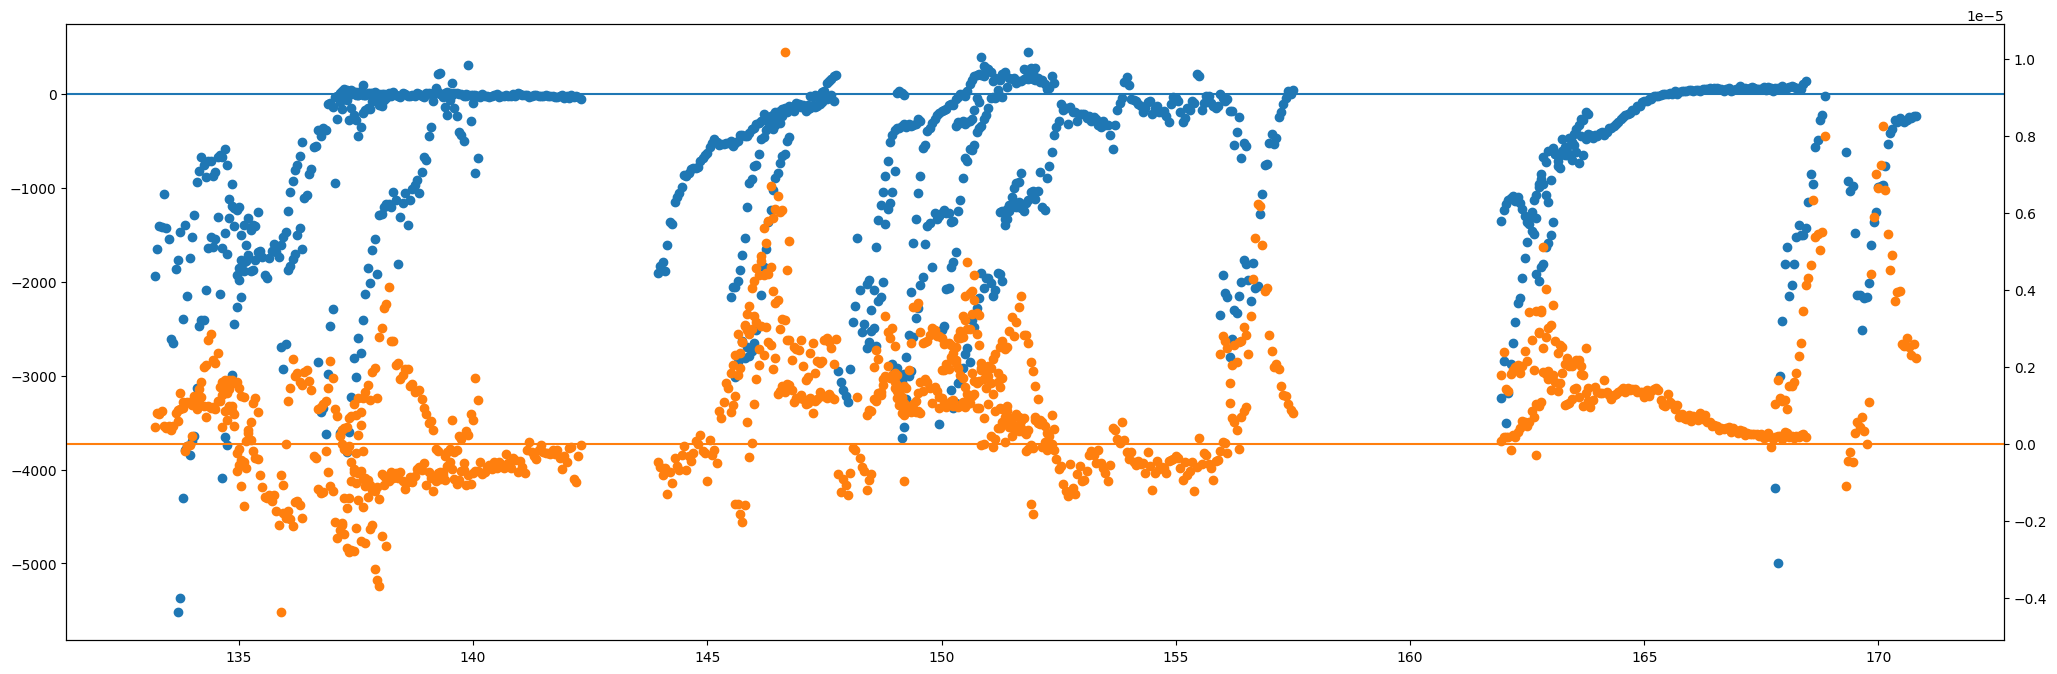

In [208]:
fig,ax = plt.subplots(figsize=(25,8))
ax2 = ax.twinx()
plot1=ax.scatter(my_df['time'],my_df['uey'])#/my_df['uix'],c=my_df['r_e'])
plot2=ax2.scatter(my_df['time'],-my_df['Jx']*my_df['Bz'],c='tab:orange')
ax.axhline(y=0,c='tab:blue')
ax2.axhline(y=0,c='tab:orange')
#ax.set_ylim(-2,2)
fig.colorbar(plot)
#my_df['duex_dt']

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_13420/1695295179.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 2500x800 with 20 Axes> than <Figure size 1200x800 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(plot)


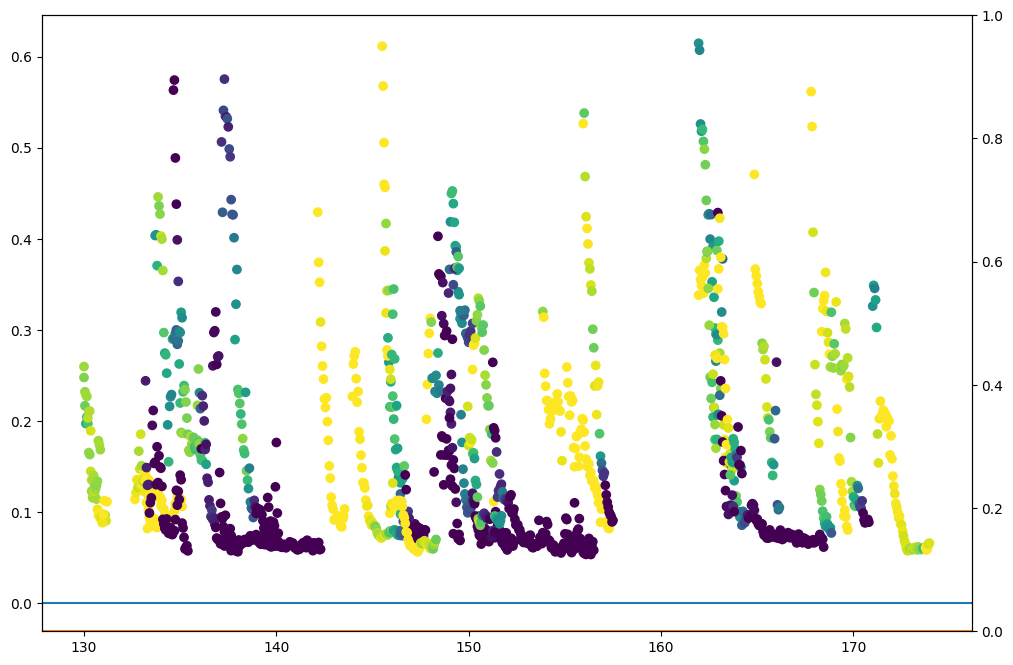

In [219]:
fig,ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
#plot1=ax.scatter(my_df['X'],my_df['Y'],c=my_df['frac_closed'])
ax.scatter(my_df['time'],my_df['APhi'],c=my_df['frac_ropey'])
ax.axhline(y=0,c='tab:blue')
ax2.axhline(y=0,c='tab:orange')
#ax.set_ylim(-2,2)
fig.colorbar(plot)
#my_df['duex_dt']

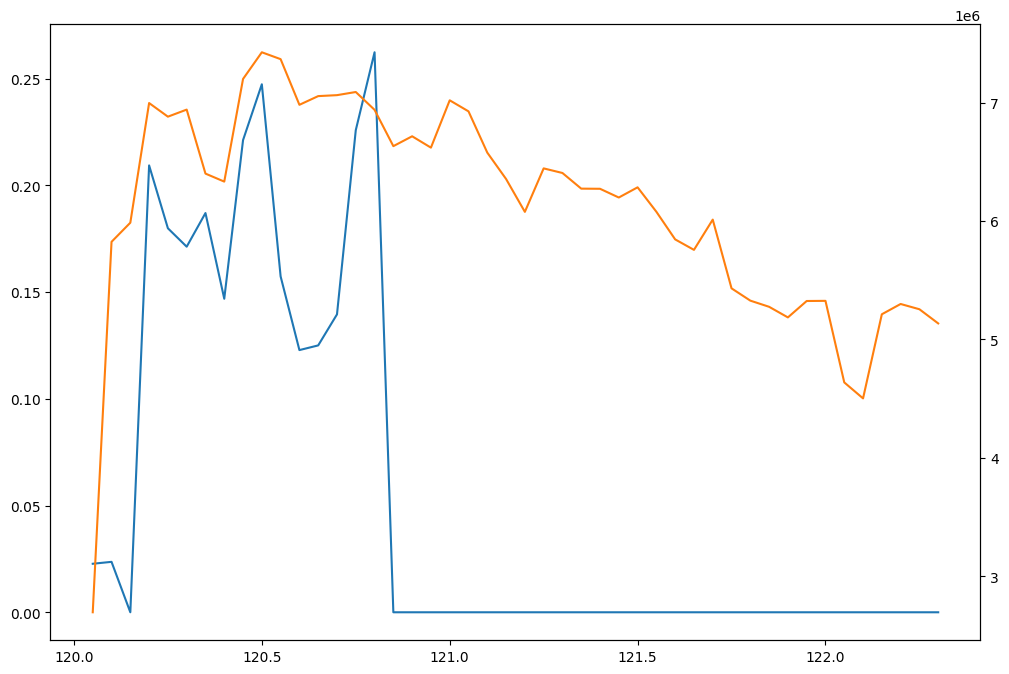

In [294]:
fig,ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
num=202
ax.plot(df_data[num]['time'],df_data[num]["frac_ropey"])
#ax.plot(df_data[num]['time'],df_data[num]["APhi"],color='tab:green')
ax2.plot(df_data[num]['time'],df_data[num]["n"]*(df_data[num]["Ti"]+df_data[num]["Te"]),color='tab:orange')

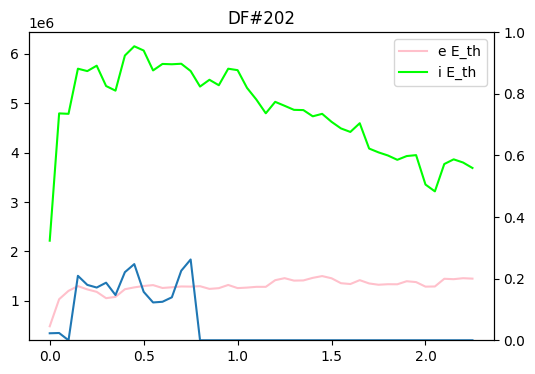

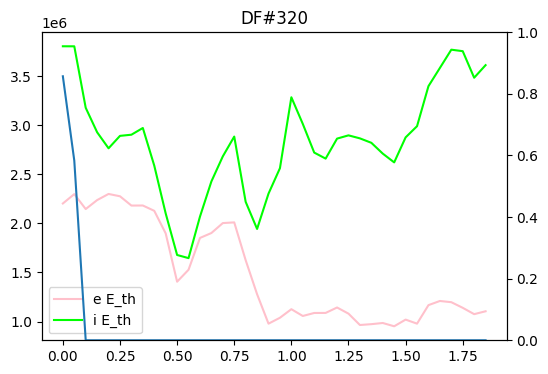

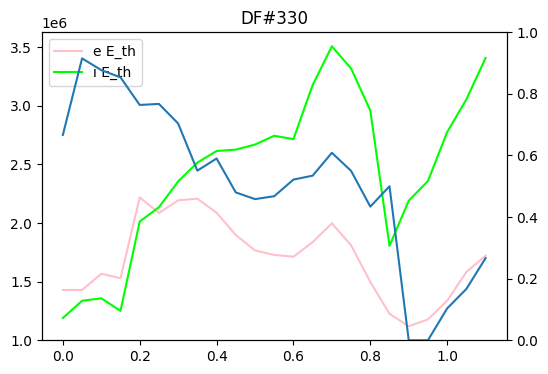

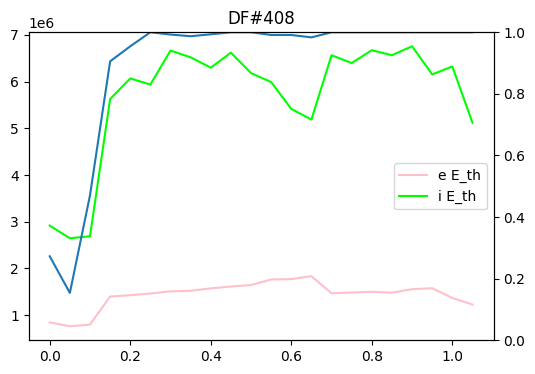

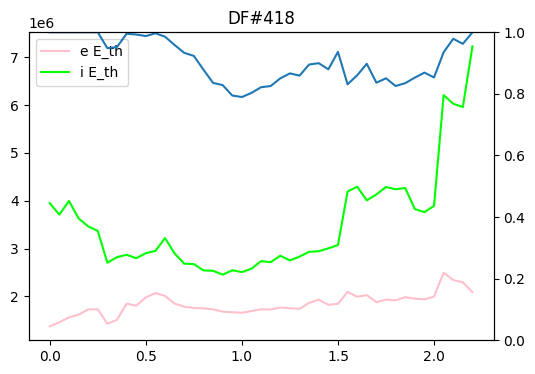

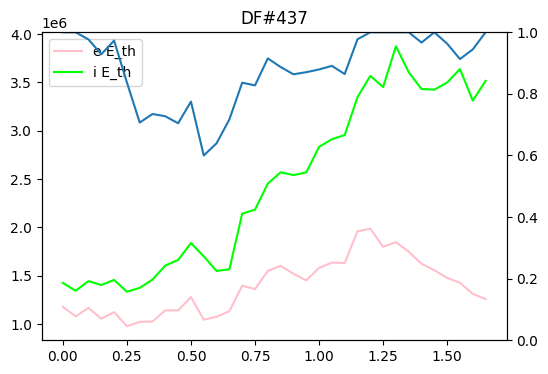

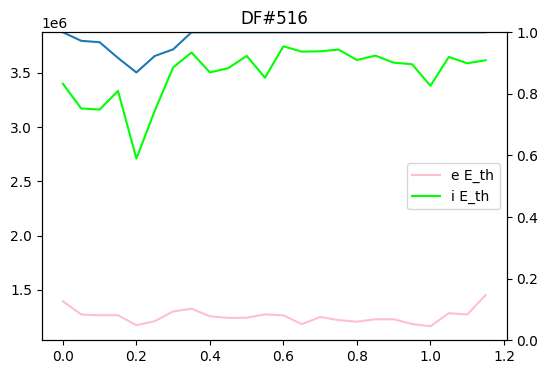

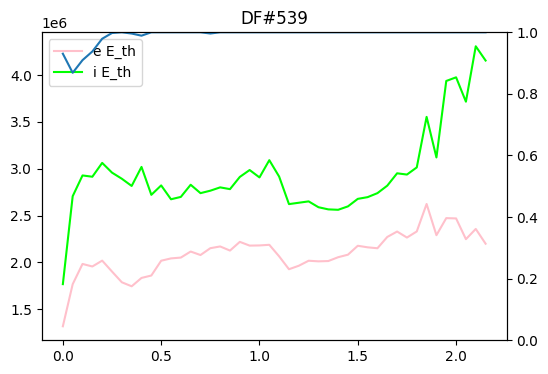

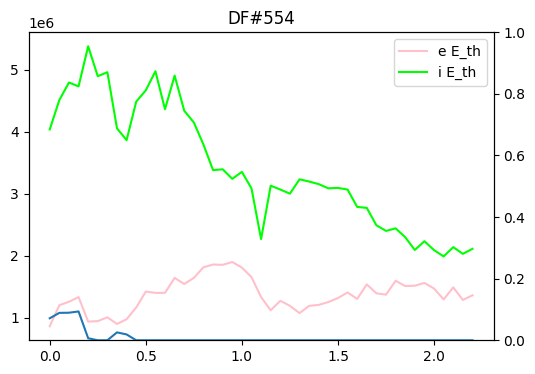

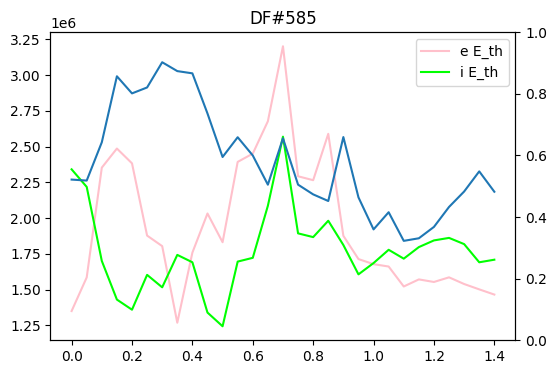

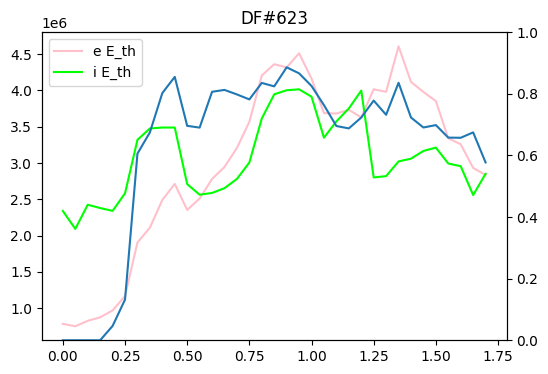

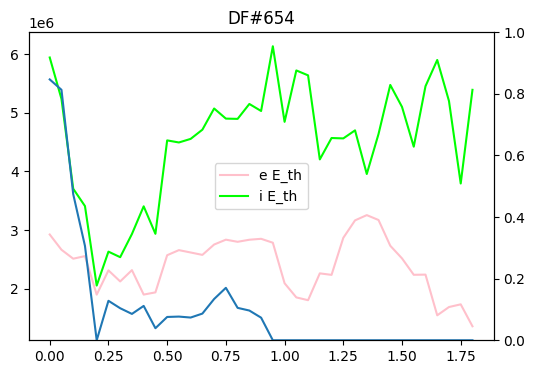

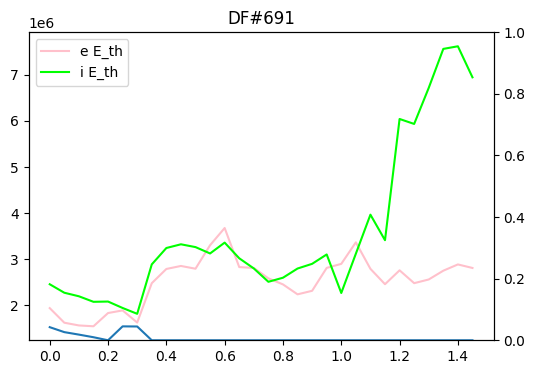

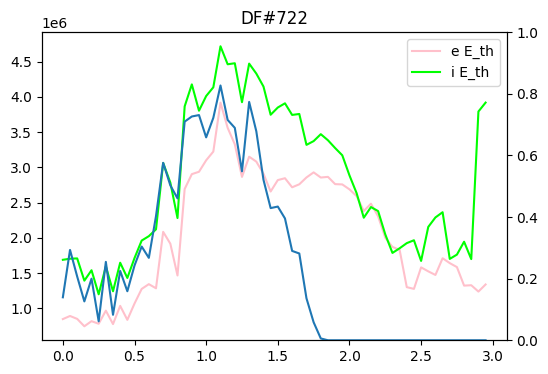

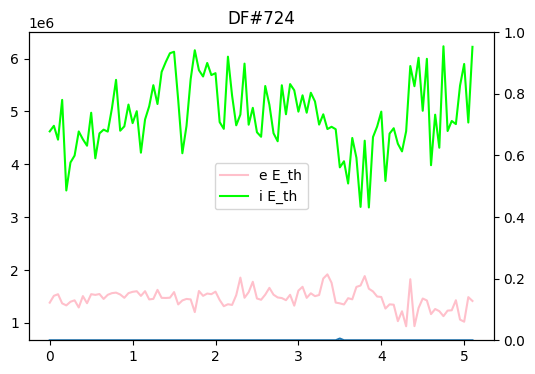

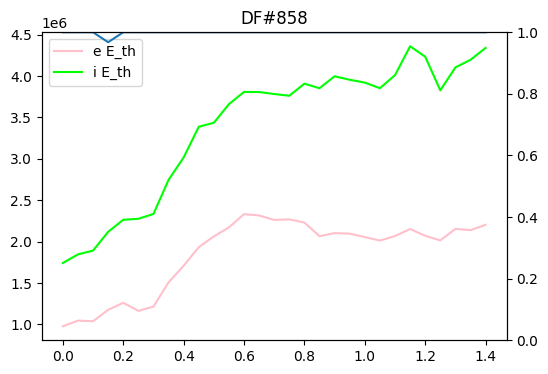

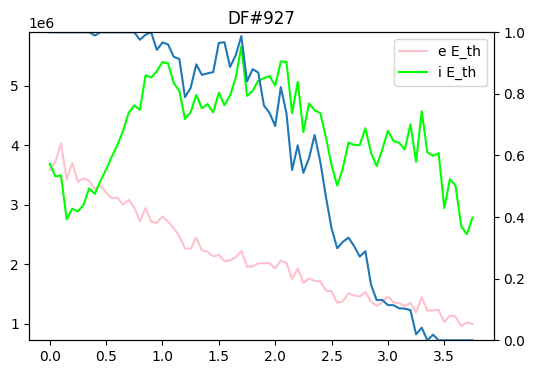

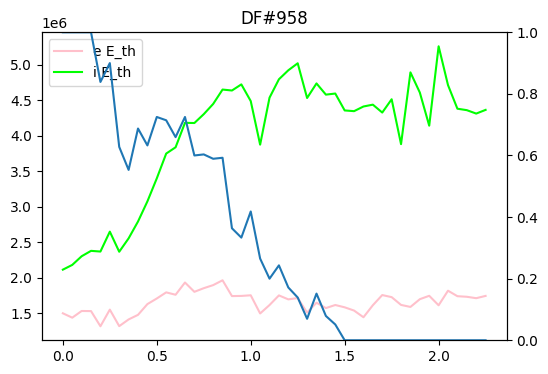

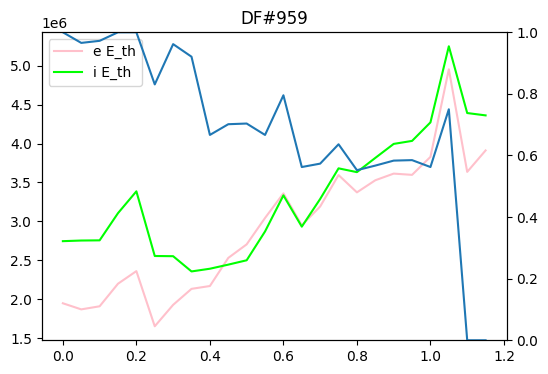

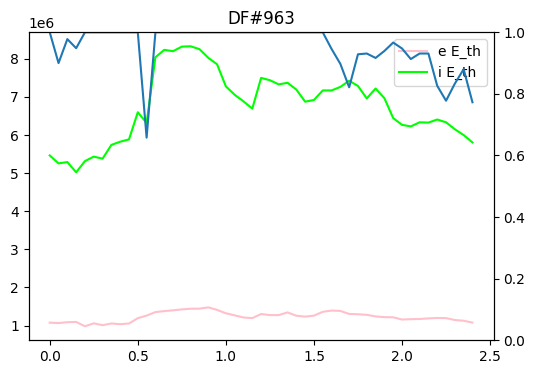

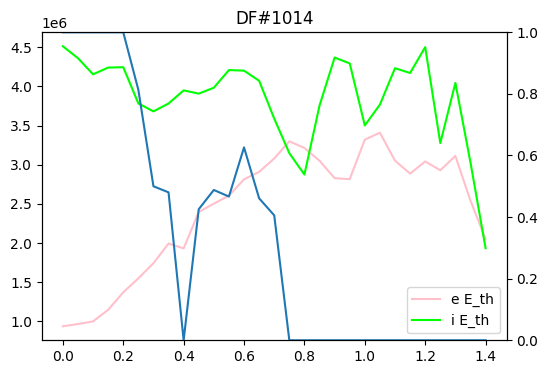

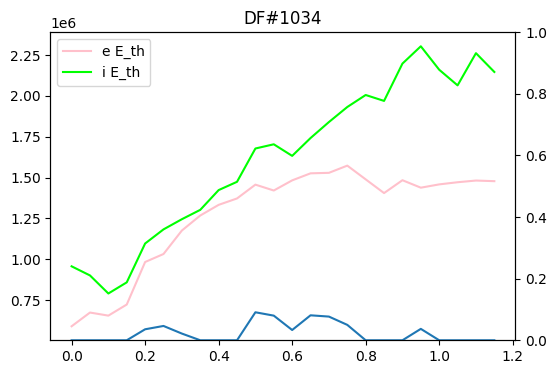

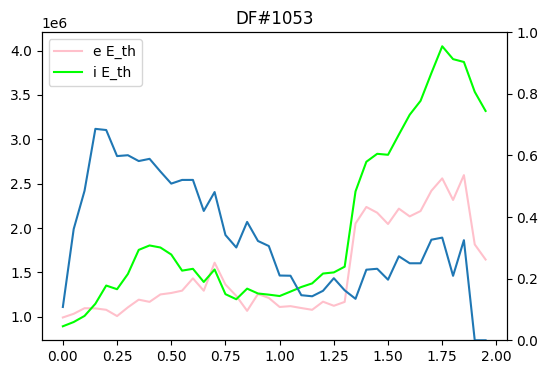

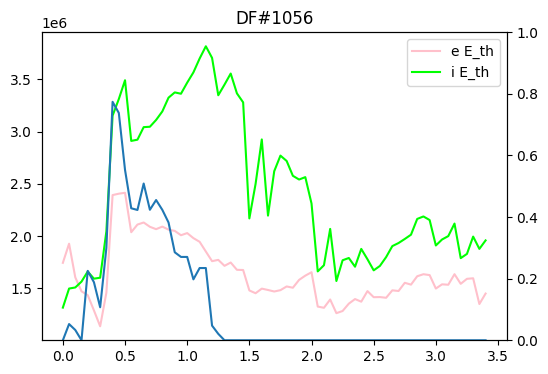

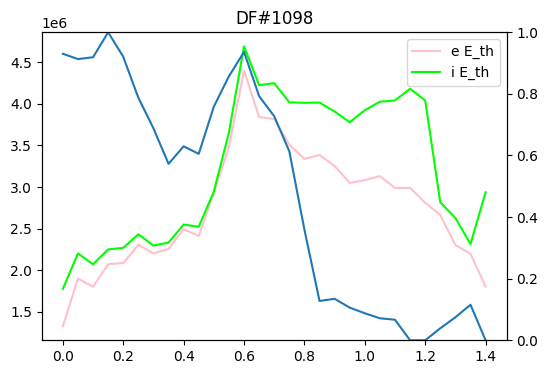

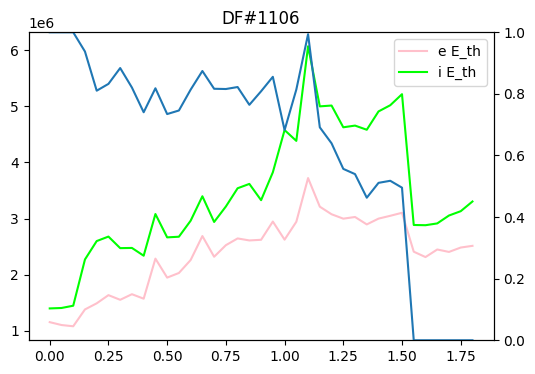

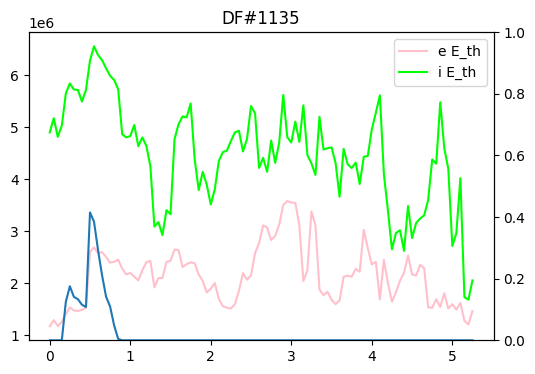

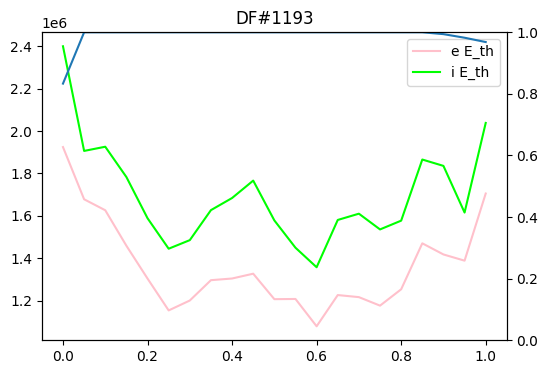

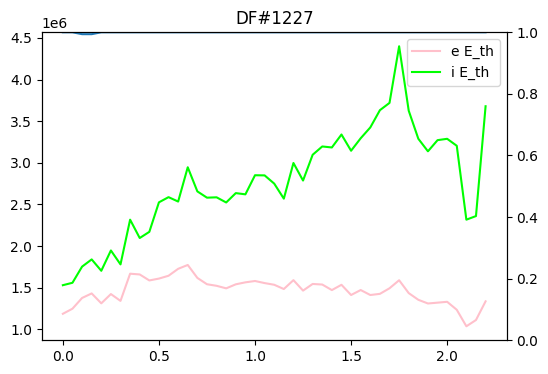

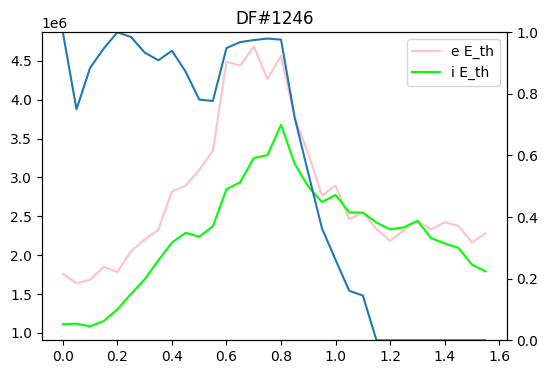

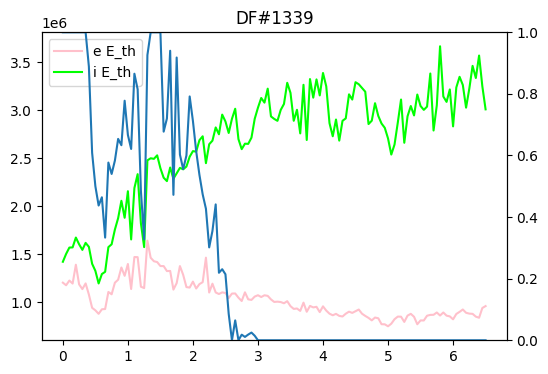

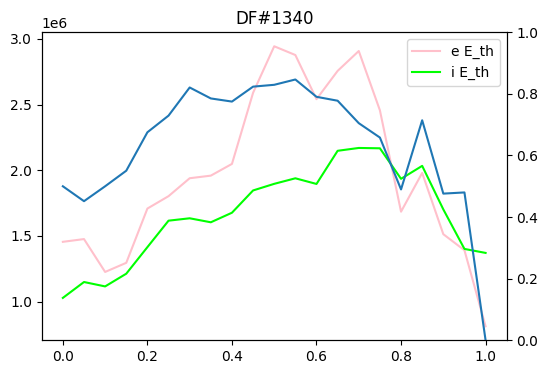

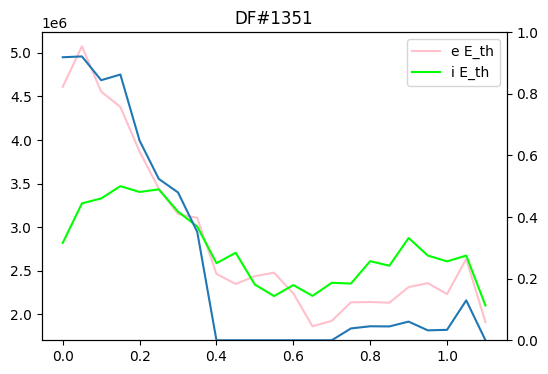

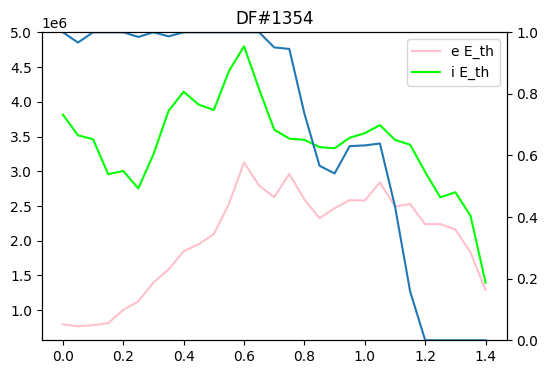

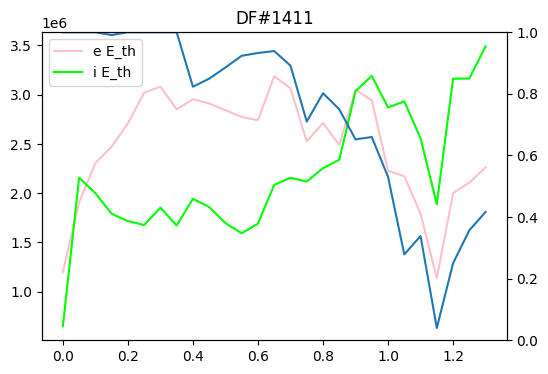

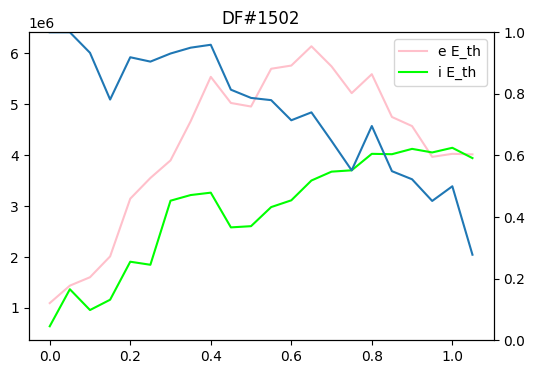

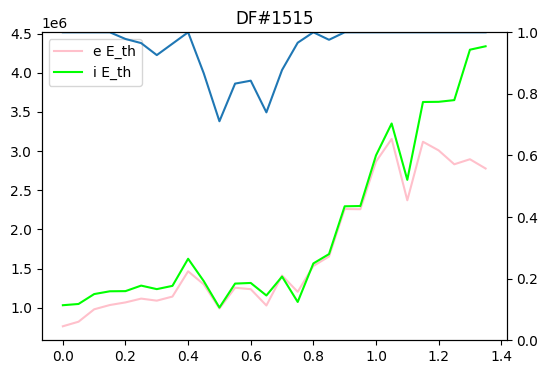

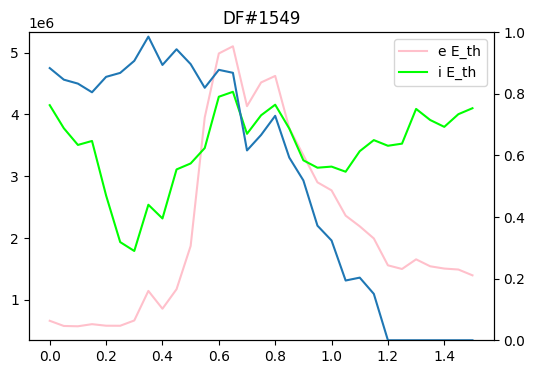

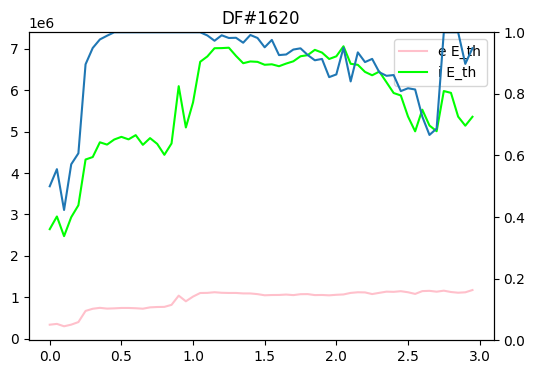

In [299]:
for key,val in df_data.items():
    if len(val)>20 and np.mean(val["X"].diff())>0:
        fig,ax = plt.subplots(figsize=(6,4))
        ax2 = ax.twinx()
        ax.plot(val['time']-val['time'][0],val["n"]*val["Te"],label='e E_th',color='pink')
        ax.plot(val['time']-val['time'][0],val["n"]*val["Ti"],label='i E_th',color='lime')
        ax2.plot(val['time']-val['time'][0],val["frac_ropey"],color='tab:blue')
        #ax.set_ylim(0,5)
        ax2.set_ylim(0,1)
        ax.set_title(str("DF#"+str(key)))
        ax.legend()
        plt.show()
        plt.close()

In [290]:
with open(dir+"dfs/df_927", 'rb') as f:
    temp_dict = pickle.load(f)

In [292]:
temp_dict[146]

[array([-1.71094, -1.71094, -1.72656, -1.71094, -1.71094, -1.72656,
        -1.71094, -1.69531, -1.72656, -1.71094, -1.69531, -1.80469,
        -1.71094, -1.83594, -1.82031, -1.80469, -1.78906, -1.72656,
        -1.71094, -1.83594, -1.82031, -1.78906, -1.77344, -1.74219,
        -1.71094, -1.77344, -1.74219, -1.72656, -1.71094, -1.78906,
        -1.77344, -1.75781, -1.74219, -1.72656, -1.78906, -1.72656,
        -1.72656, -1.72656, -1.74219, -1.72656, -1.72656, -1.72656,
        -1.69531, -1.67969, -1.72656, -1.71094, -1.69531, -1.67969,
        -1.66406, -1.64844, -1.72656, -1.71094, -1.69531, -1.67969,
        -1.66406, -1.64844, -1.63281, -1.61719, -1.71094, -1.69531,
        -1.67969, -1.66406, -1.64844, -1.63281, -1.61719, -1.71094,
        -1.69531, -1.67969, -1.66406, -1.64844, -1.61719, -1.69531,
        -1.66406], dtype=float32),
 array([-0.757812, -0.742188, -0.726562, -0.726562, -0.710938, -0.695312,
        -0.695312, -0.695312, -0.679688, -0.679688, -0.679688, -0.664062,
 

In [51]:
df_data[7]["Jx"]

0    -7.678778e-08
1    -8.500972e-08
2    -9.032744e-08
3    -7.680559e-08
4    -7.402057e-08
5    -8.341430e-08
6    -7.909989e-08
7    -8.869859e-08
8    -8.851683e-08
9    -8.062890e-08
10   -5.998822e-08
11   -7.637009e-08
12   -7.802966e-08
13   -7.962168e-08
14   -9.634848e-08
15   -1.079115e-07
16   -4.455757e-08
17   -1.638390e-07
18   -6.846847e-08
19   -2.786412e-08
20   -4.515159e-08
21   -1.567654e-08
22    7.513201e-09
23    4.141914e-08
24   -4.728101e-08
Name: Jx, dtype: float64